<h1 style="text-align: center;">Data Exploratory Analysis and Processing<h1>

Prepare libraries

In [ ]:
!pip -q install --no-deps ppscore
!pip uninstall pandas
!pip install 'pandas<2.0.0,>=1.0.0'
!pip install python-geohash


In [1]:
import pandas as pd
import time
from scipy.stats import chi2_contingency
import ppscore as pps
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes  import MultinomialNB
from datetime import datetime
import geohash

warnings.filterwarnings('ignore')

Download data

In [ ]:
!gdown 1s0Q7Jk_C3q-aOfp7tJGuYdKEFByMcDmb
!unzip /content/chicago-traffic-dataset.zip -d /content/dataset

In [2]:
crashes_df = pd.read_csv("/content/dataset/traffic-crashes.csv")
vehicles_df = pd.read_csv("/content/dataset/traffic-crashes-vehicles.csv")
people_df = pd.read_csv("/content/dataset/traffic-crashes-people.csv")
street_df = pd.read_csv("/content/dataset/chicago-street-center-lines.csv")
police_df = pd.read_csv("/content/dataset/chicago-police-beat-boundries.csv")
cbd_df = pd.read_csv("/content/dataset/chicago-CBD-boundary.csv")

In [ ]:
pd.set_option('display.max_columns', None)

# Question [1]: Data Cleaning & Integration

## [a] Fill Gaps

### [1]

#### People


First, We need to list the coulmns we have in our dataset and observe the different types of columns in the dataframe.

In [3]:
numeric_df = people_df.select_dtypes(include=[float, int]).sum()
numeric_df

VEHICLE_ID          1.507641e+12
SEAT_NO             1.521609e+06
AGE                 4.854193e+07
BAC_RESULT VALUE    3.440100e+02
dtype: float64

All of the columns along with their types.

In [4]:
print(people_df.dtypes)


PERSON_ID                 object
PERSON_TYPE               object
CRASH_RECORD_ID           object
VEHICLE_ID               float64
CRASH_DATE                object
SEAT_NO                  float64
CITY                      object
STATE                     object
ZIPCODE                   object
SEX                       object
AGE                      float64
DRIVERS_LICENSE_STATE     object
DRIVERS_LICENSE_CLASS     object
SAFETY_EQUIPMENT          object
AIRBAG_DEPLOYED           object
EJECTION                  object
INJURY_CLASSIFICATION     object
HOSPITAL                  object
EMS_AGENCY                object
EMS_RUN_NO                object
DRIVER_ACTION             object
DRIVER_VISION             object
PHYSICAL_CONDITION        object
PEDPEDAL_ACTION           object
PEDPEDAL_VISIBILITY       object
PEDPEDAL_LOCATION         object
BAC_RESULT                object
BAC_RESULT VALUE         float64
CELL_PHONE_USE            object
dtype: object


We are going to get the ratio of NaN valeus in each colummn.


In [5]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")

The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 2.00%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 79.79%
The ratio of NaN values in the 'CITY' column is: 27.21%
The ratio of NaN values in the 'STATE' column is: 26.13%
The ratio of NaN values in the 'ZIPCODE' column is: 33.19%
The ratio of NaN values in the 'SEX' column is: 1.66%
The ratio of NaN values in the 'AGE' column is: 29.19%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 41.40%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 51.01%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.28%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 1.92%
The ratio of NaN values in the 'EJECTION' column is: 1.24%
The ratio of

We observed high ratio in some columns (more than 90%) and they contribute in the following tasks so we are going to dop them.

In [6]:
columns_to_drop = [ 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']
people_df = people_df.drop(columns=columns_to_drop)


The hospital column has high ratio of NaN values so we going to study the values that the columns has.

In [7]:
people_df['HOSPITAL'].value_counts()


REFUSED                           99256
DNA                               37657
NONE                              20680
99                                 7314
DECLINED                           6789
                                  ...  
WILL SEEK MEDICAL TREATMENT           1
WILL SEEK MEDICAL ATTENTION           1
STROGER HOSPITAL (COOK COUNTY)        1
PRESENCE HEALTH/CFMC                  1
DECLINED BY PARENTS                   1
Name: HOSPITAL, Length: 7338, dtype: int64

Before deciding whethere to drop it or not we will study its relaions with other columns we are using so We will use the chi square test since it is a non-parametric test, which means it does not assume the data follows a particular distribution. The chi square helps us to determine the dependency between the columns.  

In [8]:
non_nan_hospitals = people_df['HOSPITAL'].dropna()
contingency_table = pd.crosstab(non_nan_hospitals, people_df['CITY'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic =", chi2)
print("p-value =", p)

Chi-square statistic = 33538152.529732052
p-value = 0.6039508934927641


In [9]:
non_nan_hospitals = people_df['HOSPITAL'].dropna()
contingency_table = pd.crosstab(non_nan_hospitals, people_df['STATE'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic =", chi2)
print("p-value =", p)

Chi-square statistic = 311312.9851359175
p-value = 1.0


the results indicating that there is no significant association between the columns, as the p-value is greater than 0.05. This means that the columns are independent of each other. So we are dropping this column.

In [10]:
people_df = people_df.drop(columns='HOSPITAL')

in order to keep our data clean we will dropp the NaN value of the ratio that is below 2% to ensure that no NaN values left.

In [11]:
columns_to_drop = []
threshold = 0.02  # 2%

for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count

    if nan_ratio <= threshold:
        columns_to_drop.append(column)

if columns_to_drop:
    people_df = people_df.dropna(subset=columns_to_drop)

Now we will test the NaN ratios again:

In [12]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 80.70%
The ratio of NaN values in the 'CITY' column is: 26.66%
The ratio of NaN values in the 'STATE' column is: 25.99%
The ratio of NaN values in the 'ZIPCODE' column is: 32.36%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 28.55%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 39.26%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 49.22%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'EJECTION' column is: 0.00%
The ratio of

As for the age column we will fill the NaN values with the median since we have asymmetric data.

In [13]:
people_df['AGE'].fillna(people_df['AGE'].median(), inplace=True)

Regarding the SEAT_NO feature we will fill the values according to the most frequent valeus in each SEX and AGE uniqe group.
For example the seat number would be 1 (driver) when the age is 35 and sex is male.

In [14]:
df1 = people_df.dropna(subset=['SEX', 'AGE','SEAT_NO'])

mode_seat_no = df1.groupby(['SEX', 'AGE'])['SEAT_NO'].agg(lambda x: pd.Series.mode(x)[0])
people_df['SEAT_NO'] = people_df['SEAT_NO'].fillna(pd.Series(people_df.set_index(['SEX', 'AGE']).index.map(mode_seat_no)))



testing the NaN values after the changes.


In [15]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 2.85%
The ratio of NaN values in the 'CITY' column is: 26.66%
The ratio of NaN values in the 'STATE' column is: 25.99%
The ratio of NaN values in the 'ZIPCODE' column is: 32.36%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 39.26%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 49.22%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'EJECTION' column is: 0.00%
The ratio of N

we can see that after this process we still have 2.85% NaN values so we will fill them using the most frequent.

In [16]:
mode_seat_no = people_df['SEAT_NO'].mode()[0]

people_df['SEAT_NO'].fillna(mode_seat_no, inplace=True)

testing again:

In [17]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 26.66%
The ratio of NaN values in the 'STATE' column is: 25.99%
The ratio of NaN values in the 'ZIPCODE' column is: 32.36%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 39.26%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 49.22%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'EJECTION' column is: 0.00%
The ratio of N

We will study the EJECTION feature values:

In [18]:
(people_df['EJECTION']!='NONE').value_counts()

False    1633533
True      111312
Name: EJECTION, dtype: int64

after handling the NaN values we will try to find how much NONE and UNKNOWN valeus we have and if they add meaning or they are just missing values.

In [19]:
for column in people_df.columns:
    UNKOWN_count = (people_df[column] =='UNKNOWN').sum()
    NONE_count = (people_df[column] =='NONE').sum()
    # nan_count = df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = (NONE_count+UNKOWN_count) / total_count
    print(f"The ratio of UNKOWN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of UNKOWN values in the 'PERSON_ID' column is: 0.00%
The ratio of UNKOWN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of UNKOWN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of UNKOWN values in the 'VEHICLE_ID' column is: 0.00%
The ratio of UNKOWN values in the 'CRASH_DATE' column is: 0.00%
The ratio of UNKOWN values in the 'SEAT_NO' column is: 0.00%
The ratio of UNKOWN values in the 'CITY' column is: 0.37%
The ratio of UNKOWN values in the 'STATE' column is: 0.00%
The ratio of UNKOWN values in the 'ZIPCODE' column is: 0.01%
The ratio of UNKOWN values in the 'SEX' column is: 0.00%
The ratio of UNKOWN values in the 'AGE' column is: 0.00%
The ratio of UNKOWN values in the 'DRIVERS_LICENSE_STATE' column is: 0.00%
The ratio of UNKOWN values in the 'DRIVERS_LICENSE_CLASS' column is: 0.00%
The ratio of UNKOWN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of UNKOWN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of UNKOWN values in the

We noticed that the EJECTION has 99.7 % None values and they are not exepersive since the valeus are boolean. So we are going to drop this feature.

In [20]:
people_df = people_df.drop(columns='EJECTION')

#### Vehicles

In [21]:
vehicles_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,1634931.0,NaN,NISSAN,SENTRA,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717574,2603ff5a88f0b9b54576934c5ed4e4a64e8278e005687b...,12/06/2023 04:00:00 PM,2,DRIVER,1634978.0,NaN,CHRYSLER,SEBRING,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,1634948.0,NaN,SUBARU,OUTBACK,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1720118,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,1,DRIVER,1637401.0,NaN,TOYOTA,RAV4,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1720119,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,2,DRIVER,1637408.0,NaN,SUBARU,OUTBACK,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Useful features:
1. `CRASH_DATE`: The date and time of the crash could be useful in identifying patterns such as more crashes occurring at certain times of day or certain days of the week.
2. `UNIT_TYPE`: This could help identify if certain types of vehicles are more prone to accidents.
3. `VEHICLE_ID`: This could be used to track if certain vehicles are involved in multiple accidents.
4. `VEHICLE_DEFECT`: A defect in the vehicle could certainly be a cause of a crash.
5. `VEHICLE_TYPE`: Certain types of vehicles might be more prone to accidents.
6. `TRAVEL_DIRECTION`: This could help identify if certain directions are more risky.
7.  `MANEUVER`: This could help identify if certain maneuvers are more risky.
8. `MAKE`: Certain manufacturers may have specific models that are more prone to accidents due to design, performance characteristics, or other factors.
9. `MODEL`: Some models may have higher accident rates due to factors such as their size, weight, handling characteristics, or safety features.





##### Unuseful features:
- `AREA_00_I` to `AREA_99_I` and `HAZMAT_PLACARDS_I`, `HAZMAT_NAME`, `UN_NO`, `HAZMAT_PRESENT_I`, `HAZMAT_REPORT_I`, `HAZMAT_REPORT_NO`, `MCS_REPORT_I`, `MCS_REPORT_NO`, `HAZMAT_OUT_OF_SERVICE_I`, `MCS_OUT_OF_SERVICE_I`, `HAZMAT_CLASS`: Without more information on what these represent, it's hard to say how useful they are.
- `FIRE_I`: Since our primary focus is on identifying the causes of crashes, the occurrence of a fire after accident falls outside the scope of our investigation.

This is subject to change depending on the results of our exploratory analysis.

First, we'll take a look at the ratio of NaN values in each column in our vehicles dataframe. If a column has more than 80% empty spots, it might be hard to study, and finding these empty spots might not be practical.

In [22]:
def show_missing_values(percent, df):
  info_df = pd.DataFrame()
  info_df['missing_val'] = df.isnull().sum()
  info_df['missing_val_ratio'] = (info_df['missing_val'] / df.shape[0] * 100).round().astype(int)
  return info_df.loc[info_df['missing_val_ratio'] > percent]

In [23]:
missing_df = show_missing_values(80, vehicles_df)
print(missing_df)

                          missing_val  missing_val_ratio
CMRC_VEH_I                    1649615                 98
TOWED_I                       1472365                 88
FIRE_I                        1679517                100
EXCEED_SPEED_LIMIT_I          1678495                100
TOWED_BY                      1524003                 91
TOWED_TO                      1584546                 94
AREA_00_I                     1623152                 97
AREA_02_I                     1414448                 84
AREA_03_I                     1519765                 90
AREA_04_I                     1520419                 90
AREA_05_I                     1431572                 85
AREA_06_I                     1418159                 84
AREA_07_I                     1437278                 86
AREA_08_I                     1442051                 86
AREA_09_I                     1567324                 93
AREA_10_I                     1515546                 90
AREA_11_I                     1

As we can see, some columns have 100% and some have 99%  NaN values, and that's way too many, so let's drop these columns and move forward.

In [24]:
vehicles_df.drop(["CMRC_VEH_I", "TOWED_I", "FIRE_I", "EXCEED_SPEED_LIMIT_I", "TOWED_BY", "TOWED_TO", "AREA_00_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY", "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I", "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH", "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I", "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"], inplace=True, axis=1)

In [25]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                   2150                  0
VEHICLE_ID                 38473                  2
MAKE                       38478                  2
MODEL                      38623                  2
LIC_PLATE_STATE           188917                 11
VEHICLE_YEAR              301958                 18
VEHICLE_DEFECT             38473                  2
VEHICLE_TYPE               38473                  2
VEHICLE_USE                38473                  2
TRAVEL_DIRECTION           38473                  2
MANEUVER                   38473                  2
OCCUPANT_CNT               38473                  2
AREA_01_I                1231298                 73
FIRST_CONTACT_POINT        41596                  2


We'll run the PPScore test again to check how the columns relate to each other.

In [ ]:
mat = pps.matrix(vehicles_df)
mat = mat[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')


<Axes: title={'center': 'PPS matrix'}, xlabel='x', ylabel='y'>

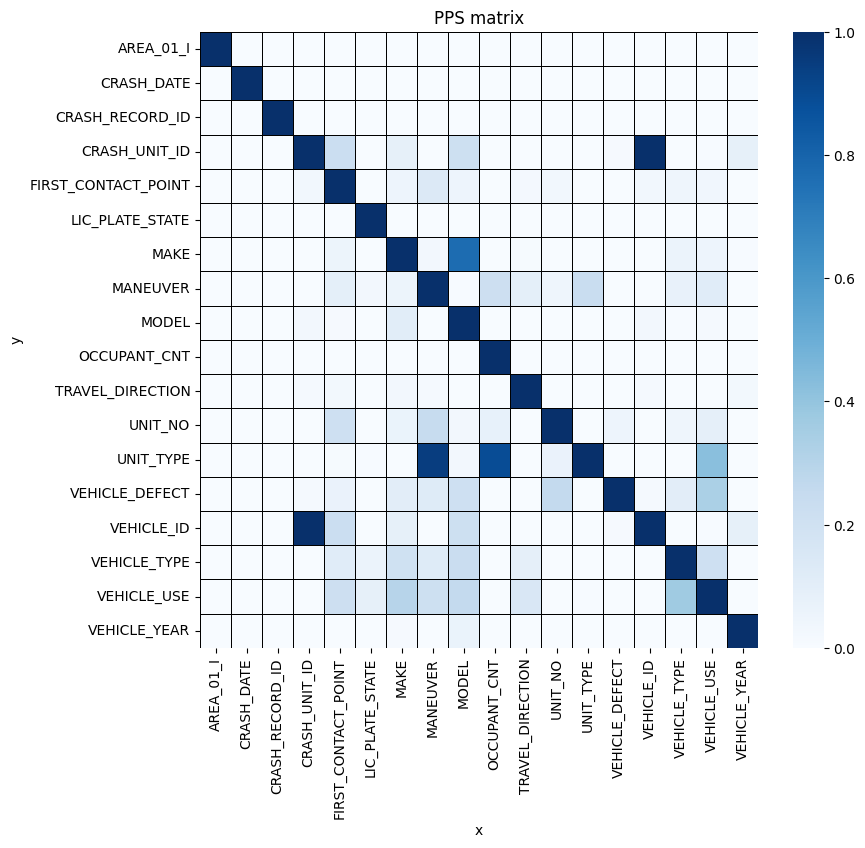

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_title("PPS matrix")
ax.set_xlabel("feature")
ax.set_ylabel("target")
sns.heatmap(mat, vmin=0, vmax=1, cmap="Blues", ax=ax, linecolor='black', linewidths=.5)

Based on our examination, the columns `AREA_01_I`, `LIC_PLATE_STATE`, and `FIRST_CONTACT_POINT` appear to have no significant connection with the rest of the data and do not provide valuable insights into the causes of a crash. Therefore, we plan to drop these columns. On the other hand, the columns `MANEUVER` and `OCCUPANT_CNT` play a crucial role in determining the `UNIT_TYPE`, so our priority will be to clean these columns.

In [ ]:
vehicles_df = vehicles_df.drop(["AREA_01_I", "LIC_PLATE_STATE", "FIRST_CONTACT_POINT"], axis=1)

#### Crashes

##### Useful features:

1. `DATE_POLICE_NOTIFIED` can be used for verifying `CRASH_DATE`.

2. `POSTED_SPEED_LIMIT` can be used to determine if a particular road has a lot of speed limit crosses. If so, it might be due to a lack of monitoring devices, warning signs or مطبات etc.

3. `TRAFFIC_CONTROL_DEVICE` might help us in determining if the used device is helping in increasing or decreasing accidents. This shouldn't be confused with `DEVICE_CONDITION` because a device can have an excellent condition but provide wrong information. For example, a street sign might show the speed limit is 100 km/h when it should be 60 km/h.

4. While the used device might be correct, its `DEVICE_CONDITION`, obviously, plays a hand in helping or confusing drivers.

5. `WEATHER_CONDITION` might be a contributing factor. A wet road can cause cars to drift away from its course. Also, If a weather condition increases accidents, it might be due to some defects in the road like water gathering in some areas. You might object that `ALIGNMENT` is addressing road alignment but you can't guarantee that it's enough. For example, a road might sound like having a perfect alignment but still, some lakes are formed when it rains which means its level should be adjusted. This defect isn't apparent without some rain.

6. `LIGHTING_CONDITION` can be a contributing factor because darkness might increase accidents. It might be beneficial to install something like a lamp post.

7. `FIRST_CRASH_TYPE` might provide some info about road safety. For example, if `FIRST_CRASH_TYPE` is `PEDESTRIAN`, it motivates us to look for any measures for increasing pedestrian safety such as putting traffic signals or road markings for pedestrian crossing.

8. `TRAFFICWAY_TYPE` column: if a `FOUR WAY` has a lot of accidents. We might check if the four ways are separated clearly or maybe put some roadblocks among them. The same applies for `LANE_CNT`.

9. `ALIGNMENT` is a useful feature too. Consider a left turn. The ground shouldn't be level and should have some slope to prevent cars from turning over.

10. `ROADWAY_SURFACE_COND` & `ROAD_DEFECT` are obvious enough.

12. `INTERSECTION_RELATED_I` is a useful feature obviously.

12. `NOT_RIGHT_OF_WAY_I` might be useful. For example, a car might get in front of another which might confuse the car behind which might lead to an accident. This column basically determines whether a car jumped in a lane out of the blue.

13. While `HIT_AND_RUN_I` doesn't provide valuable info for increasing road safety, it might be kind of useful for solving the 2nd & 3rd questions in `من الخام الى المصقول`. For example, when calculating the average number/age of passengers in each accident, we know that it's only an approximation. Because the hit-and-run car might not be included in our dataset. For calculating the number of cars involved in an accident, if `HIT_AND_RUN_I` is `yes`, we add 1 to the number of cars involved.

14. `PRIM_CONTRIBUTORY_CAUSE` & `SEC_CONTRIBUTORY_CAUSE` are obviusly useful.

15. `WORK_ZONE_I`: if an accident occurs in a work zone, it might be beneficial to take some safety measures.

16. `WORK_ZONE_TYPE`: maybe some work zones are more likely to cause accidents. It might or might not be true.

17. `WORKERS_PRESENT_I`: a crowded work zone can increase the likelihood of accidents.

18. All columns for addressing injuries can be replaced with a single column for determining the presence/absence of injuries.

##### Unuseful features:

`REPORT_TYPE`, `PHOTOS_TAKEN_I`, `STATEMENTS_TAKEN_I`, `CRASH_DATE_EST_I` and anything related to injuries aren't useful features for increasing road safety or determining accidents.

Any column that isn't mentioned in useful/unuseful features is useful for solving some question or there's no strong indication for its usefulness/unusefulness.

Too many assumptions, right ? Let's test them.

##### Basic EDA

In [ ]:
info_df = pd.DataFrame()
info_df['missing_val'] = crashes_df.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / crashes_df.shape[0] * 100).round().astype(int)
info_df.loc[info_df['missing_val_ratio'] > 80]

,missing_val,missing_val_ratio
CRASH_DATE_EST_I,762398,93
NOT_RIGHT_OF_WAY_I,785972,95
PHOTOS_TAKEN_I,813076,99
STATEMENTS_TAKEN_I,805506,98
DOORING_I,821426,100
WORK_ZONE_I,819259,99
WORK_ZONE_TYPE,820323,100
WORKERS_PRESENT_I,822755,100


Too many missing values. Let's drop them.

In [26]:
crashes_df.drop(['CRASH_DATE_EST_I', 'NOT_RIGHT_OF_WAY_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'], inplace=True, axis=1)

In [ ]:
info_df = pd.DataFrame()
info_df['missing_val'] = crashes_df.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / crashes_df.shape[0] * 100).round().astype(int)
info_df.loc[info_df['missing_val'] > 0]

,missing_val,missing_val_ratio
LANE_CNT,624947,76
REPORT_TYPE,24578,3
INTERSECTION_RELATED_I,635017,77
HIT_AND_RUN_I,565983,69
STREET_DIRECTION,4,0
STREET_NAME,1,0
BEAT_OF_OCCURRENCE,5,0
MOST_SEVERE_INJURY,1812,0
INJURIES_TOTAL,1799,0
INJURIES_FATAL,1799,0


In [ ]:
mat = pps.matrix(crashes_df)
mat = mat[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_title("PPS matrix")
ax.set_xlabel("feature")
ax.set_ylabel("target")
sns.heatmap(mat, vmin=0, vmax=1, cmap="Blues", ax=ax, linecolor='black', linewidths=.5)

The reason for choosing PPS is that it:
1. recognises asymmetrical relationships.
2. can handle categorical data.
3. works well for linear and non-linear relationships.
4. excels at measuring both monotonic and non-monotonic relationships.

Injuries-related columns don't seem to provide valuable info because they only affect other injuries-related columns Let's drop them.

In [27]:
crashes_df.drop(['MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'REPORT_TYPE'], inplace=True, axis=1)

In [28]:
info_df = pd.DataFrame()
info_df['missing_val'] = crashes_df.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / crashes_df.shape[0] * 100).round().astype(int)
info_df.loc[info_df['missing_val'] > 0]

,missing_val,missing_val_ratio
LANE_CNT,624947,76
INTERSECTION_RELATED_I,635017,77
HIT_AND_RUN_I,565983,69
STREET_DIRECTION,4,0
STREET_NAME,1,0
BEAT_OF_OCCURRENCE,5,0
LATITUDE,5690,1
LONGITUDE,5690,1
LOCATION,5690,1


##### Dropping columns

###### `HIT_AND_RUN_I`

In [ ]:
crashes_df['HIT_AND_RUN_I'].value_counts()

Maybe if the damage is too large, it's more likely to hit-and-run. Let's see.

In [ ]:
crashes_df[['DAMAGE', 'HIT_AND_RUN_I']].value_counts()

It's true but we can't gaurantee that it generalizes well. Also, `HIT_AND_RUN_I` isn't co-related with any column. Let's drop it.

In [ ]:
crashes_df.drop('HIT_AND_RUN_I', inplace=True, axis=1)

###### `LANE_CNT`

According to [this source](https://www.politifact.com/factchecks/2016/apr/13/sylvester-turner/worlds-widest-highway-not-where-sylvester-turner-t/), 26 is the upper limit for `LANE_CNT` in US.

In [ ]:
fig, ax = plt.subplots()
crashes_df['LANE_CNT'].value_counts().plot(ax=ax, kind='bar')
ax.set_yscale('log')
ax.set_xlabel('LANE_CNT')
ax.set_ylabel('Count')

In [ ]:
crashes_df['TRAFFICWAY_TYPE'].unique()

`TRAFFICWAY_TYPE` contains labels like `ONE-WAY` & `FOUR WAY` which provide info about `LANE_CNT`. Let's drop `LANE_CNT`.

In [ ]:
crashes_df.drop('LANE_CNT', inplace=True, axis=1)

###### `INTERSECTION_RELATED_I`

In [ ]:
crashes_df['INTERSECTION_RELATED_I'].unique()

In [ ]:
crashes_df['TRAFFICWAY_TYPE'].unique()

`TRAFFICWAY_TYPE` contains labels like `L-INTERSECTION` & `Y-INTERSECTION`. No need for `INTERSECTION_RELATED_I`. Let's drop it.

In [ ]:
crashes_df.drop('INTERSECTION_RELATED_I', inplace=True, axis=1)

### [2]

#### People

In this section we will continue our method to detect and handle NaN values:

regarding the address features we will try to use one address featre like city to fill NaN values in other address feature:

In [29]:
df1 = people_df.dropna(subset=['CITY'])

mode_zip_code = df1.groupby('CITY')['ZIPCODE'].agg(pd.Series.mode)
people_df['ZIPCODE'] = people_df['ZIPCODE'].fillna(people_df['CITY'].map(mode_zip_code))
print(mode_zip_code)


CITY
,HARWOOD HEIGHTS             60706
.BRIDGEVIEW                  60455
.CHICAGO                        []
0AK PARK                     60301
1                   [60628, 60636]
                         ...      
`CHICAGO                     60639
`CHICAGO RIDGE               60415
`EVERGREEN PARK              60805
`FLOSSMOOR                   60422
`RIVERDALE                   60827
Name: ZIPCODE, Length: 13224, dtype: object


In [30]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 26.66%
The ratio of NaN values in the 'STATE' column is: 25.99%
The ratio of NaN values in the 'ZIPCODE' column is: 26.42%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 39.26%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 49.22%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
T

according to this we observed that the pervious method didn't handled more than 2% of the NaN which means that mostly the NaN values exist in the three features of address in the same records.
so for that and since we need the these features and we can't get the location from other features so we will drop the NaN values.

In [31]:
people_df = people_df.dropna(subset=['CITY', 'STATE', 'ZIPCODE'], how='all')


In [32]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 2.53%
The ratio of NaN values in the 'STATE' column is: 1.64%
The ratio of NaN values in the 'ZIPCODE' column is: 2.22%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 23.04%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 33.84%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
The 

for the DRIVERS_LICENSE_STATE column we will fill the NaN values using the most frequesnt in each city:





In [33]:
df1 = people_df.dropna(subset=['CITY'])

mode_zip_code = df1.groupby('CITY')['DRIVERS_LICENSE_STATE'].agg(pd.Series.mode)
people_df['DRIVERS_LICENSE_STATE'] = people_df['DRIVERS_LICENSE_STATE'].fillna(people_df['CITY'].map(mode_zip_code))
print(mode_zip_code)


CITY
,HARWOOD HEIGHTS    []
.BRIDGEVIEW         IL
.CHICAGO            IL
0AK PARK            IL
1                   IL
                    ..
`CHICAGO            IL
`CHICAGO RIDGE      IL
`EVERGREEN PARK     IL
`FLOSSMOOR          []
`RIVERDALE          IL
Name: DRIVERS_LICENSE_STATE, Length: 13224, dtype: object


The NaN values Now:

In [34]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 2.53%
The ratio of NaN values in the 'STATE' column is: 1.64%
The ratio of NaN values in the 'ZIPCODE' column is: 2.22%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 2.31%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 33.84%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
The r

for the DRIVERS_LICENSE_CLASS column we will fill the NaN values using the most frequesnt in each city:

In [35]:
df1 = people_df.dropna(subset=['CITY'])

mode_city_class = df1.groupby('CITY')['DRIVERS_LICENSE_CLASS'].agg(pd.Series.mode)
people_df['DRIVERS_LICENSE_CLASS'] = people_df['DRIVERS_LICENSE_CLASS'].fillna(people_df['CITY'].map(mode_city_class))
print(mode_city_class)

CITY
,HARWOOD HEIGHTS    []
.BRIDGEVIEW          A
.CHICAGO             A
0AK PARK             D
1                    D
                    ..
`CHICAGO             D
`CHICAGO RIDGE      DQ
`EVERGREEN PARK      D
`FLOSSMOOR          []
`RIVERDALE           D
Name: DRIVERS_LICENSE_CLASS, Length: 13224, dtype: object


In [36]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 2.53%
The ratio of NaN values in the 'STATE' column is: 1.64%
The ratio of NaN values in the 'ZIPCODE' column is: 2.22%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 2.31%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 2.39%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
The ra

We will also use the city to get the most frequent BAC_RESULT in each city

In [37]:
df1 = people_df.dropna(subset=['CITY'])

mode_zip_code = df1.groupby('CITY')['BAC_RESULT'].agg(pd.Series.mode)
people_df['BAC_RESULT'] = people_df['BAC_RESULT'].fillna(people_df['CITY'].map(mode_zip_code))
print(mode_zip_code)


CITY
,HARWOOD HEIGHTS                  []
.BRIDGEVIEW         TEST NOT OFFERED
.CHICAGO            TEST NOT OFFERED
0AK PARK            TEST NOT OFFERED
1                   TEST NOT OFFERED
                          ...       
`CHICAGO            TEST NOT OFFERED
`CHICAGO RIDGE      TEST NOT OFFERED
`EVERGREEN PARK     TEST NOT OFFERED
`FLOSSMOOR                        []
`RIVERDALE          TEST NOT OFFERED
Name: BAC_RESULT, Length: 13224, dtype: object


Since the vision conditions differ in each city we will get the most frequent case in each city to fill the NaN value sin the DRIVER_VISION feature.

In [38]:
df1 = people_df.dropna(subset=['CITY'])

mode_zip_code = df1.groupby('CITY')['DRIVER_VISION'].agg(pd.Series.mode)
people_df['DRIVER_VISION'] = people_df['DRIVER_VISION'].fillna(people_df['CITY'].map(mode_zip_code))
print(mode_zip_code)

CITY
,HARWOOD HEIGHTS              []
.BRIDGEVIEW         NOT OBSCURED
.CHICAGO            NOT OBSCURED
0AK PARK            NOT OBSCURED
1                   NOT OBSCURED
                        ...     
`CHICAGO            NOT OBSCURED
`CHICAGO RIDGE      NOT OBSCURED
`EVERGREEN PARK          UNKNOWN
`FLOSSMOOR                    []
`RIVERDALE               UNKNOWN
Name: DRIVER_VISION, Length: 13224, dtype: object


The PHYSICAL_CONDITION is related to the safety equipments available so we will use the equipments to fill the NaN valeus in PHYSICAL_CONDITION.

In [39]:

df1 = people_df.dropna(subset=['SAFETY_EQUIPMENT'])

mode_zip_code = df1.groupby('SAFETY_EQUIPMENT')['PHYSICAL_CONDITION'].agg(pd.Series.mode)
people_df['PHYSICAL_CONDITION'] = people_df['PHYSICAL_CONDITION'].fillna(people_df['SAFETY_EQUIPMENT'].map(mode_zip_code))
print(mode_zip_code)


SAFETY_EQUIPMENT
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)                       NORMAL
BOOSTER SEAT                                                      OTHER
CHILD RESTRAINT - FORWARD FACING                                     []
CHILD RESTRAINT - REAR FACING                                        []
CHILD RESTRAINT - TYPE UNKNOWN                                       []
CHILD RESTRAINT NOT USED                                             []
CHILD RESTRAINT USED                                             NORMAL
CHILD RESTRAINT USED IMPROPERLY                                      []
DOT COMPLIANT MOTORCYCLE HELMET                                  NORMAL
HELMET NOT USED                                                  NORMAL
HELMET USED                                                      NORMAL
NONE PRESENT                                                     NORMAL
NOT DOT COMPLIANT MOTORCYCLE HELMET                              NORMAL
SAFETY BELT NOT USED                           

The action that the driver takes depends on his experience so we will use the most frequest action that the driver takes in each age.

In [40]:
df1 = people_df.dropna(subset=['AGE'])

mode_zip_code = df1.groupby('AGE')['DRIVER_ACTION'].agg(pd.Series.mode)
people_df['DRIVER_ACTION'] = people_df['DRIVER_ACTION'].fillna(people_df['AGE'].map(mode_zip_code))
print(mode_zip_code)


AGE
-177.0                                  UNKNOWN
-49.0                                     OTHER
-47.0                      FOLLOWED TOO CLOSELY
-40.0                                        []
-1.0                                       NONE
                          ...                  
 106.0                                       []
 107.0                          [NONE, UNKNOWN]
 108.0                 [FAILED TO YIELD, OTHER]
 109.0    [FOLLOWED TOO CLOSELY, IMPROPER TURN]
 110.0                          [NONE, UNKNOWN]
Name: DRIVER_ACTION, Length: 116, dtype: object


the results now

In [41]:
for column in people_df.columns:
    nan_count = people_df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.08%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 2.53%
The ratio of NaN values in the 'STATE' column is: 1.64%
The ratio of NaN values in the 'ZIPCODE' column is: 2.22%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 2.31%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 2.39%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
The ra

since we have low NaN ratios and filling them will increase the errors later we will drop the NaN values.

In [42]:
df = people_df.reset_index(drop=True)
for column in people_df.columns:
    df[column].fillna(people_df[column].mode()[0], inplace=True)
    nan_count = df[column].isna().sum()
    total_count = len(people_df)
    nan_ratio = nan_count / total_count
    print(f"The ratio of NaN values in the '{column}' column is: {nan_ratio:.2%}")


The ratio of NaN values in the 'PERSON_ID' column is: 0.00%
The ratio of NaN values in the 'PERSON_TYPE' column is: 0.00%
The ratio of NaN values in the 'CRASH_RECORD_ID' column is: 0.00%
The ratio of NaN values in the 'VEHICLE_ID' column is: 0.00%
The ratio of NaN values in the 'CRASH_DATE' column is: 0.00%
The ratio of NaN values in the 'SEAT_NO' column is: 0.00%
The ratio of NaN values in the 'CITY' column is: 0.00%
The ratio of NaN values in the 'STATE' column is: 0.00%
The ratio of NaN values in the 'ZIPCODE' column is: 0.00%
The ratio of NaN values in the 'SEX' column is: 0.00%
The ratio of NaN values in the 'AGE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_STATE' column is: 0.00%
The ratio of NaN values in the 'DRIVERS_LICENSE_CLASS' column is: 0.00%
The ratio of NaN values in the 'SAFETY_EQUIPMENT' column is: 0.00%
The ratio of NaN values in the 'AIRBAG_DEPLOYED' column is: 0.00%
The ratio of NaN values in the 'INJURY_CLASSIFICATION' column is: 0.00%
The ra

**OUTLIERS:**

We will detect the age values that are below 0:

In [43]:
outliers = people_df[people_df['AGE'] < 0]
len(outliers)

8

We have 8 valeus so we will drop them

In [44]:
people_df = people_df[people_df['AGE'] > 0]

according to the law in Chicago the driver age should be between 15 and 90 and it is not logically accepted to have a driver with age below 15 and more than 90.

In [45]:
drivers = people_df[people_df['PERSON_TYPE'] == 'DRIVER']

outliers = drivers[(drivers['AGE'] < 15) | (drivers['AGE'] > 90)]
len(outliers)

1428

to handle these values we will fill them using the mode in PEROSN_TYPE feature.

In [46]:
driver_mode_age = people_df[people_df['PERSON_TYPE'] == 'DRIVER']['AGE'].mode()[0]

# Replace outliers in the 'age' column with the mode
people_df.loc[(people_df['PERSON_TYPE'] == 'DRIVER') & ((people_df['AGE'] < 15) | (people_df['AGE'] > 90)), 'AGE'] = driver_mode_age

After counting the number of states we have in our data we found two more than the actual number in US and they are not exepressive.

In [47]:
((people_df['STATE']== 'XX') | (people_df['STATE']== 'NB')).sum()

8737

we will drop these values.

In [48]:
people_df = people_df[~people_df['STATE'].isin(['XX', 'NB'])]

in order to detect the outliers in city will find the cities that occurr less than 9 times.

In [49]:
city_counts = people_df['CITY'].value_counts()

threshold = 9
outliers = city_counts[city_counts < threshold]

print(outliers)


LODA              8
ISSAQUAH          8
CHERRY HILL       8
BARABOO           8
FARIBAULT         8
                 ..
PICHTON           1
NUEVO LAREDO      1
PENSACOLA BCH     1
MINDEMOYA         1
BLUE ISLAND IL    1
Name: CITY, Length: 11458, dtype: int64


In [50]:
people_df = people_df[~people_df['CITY'].isin(outliers)]


we will detect the zip code that occurr less than 10 times:

In [51]:
zipcode_counts = people_df['ZIPCODE'].value_counts()
threshold = 10
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
len(zipcode_outliers)
people_df = people_df[~people_df['ZIPCODE'].isin(zipcode_outliers)]



In [52]:
people_df['SEX'].value_counts()

M    736920
F    547731
X      6709
Name: SEX, dtype: int64

Now for the SEAT_NO feature we will use the IQR method to detect outliers.

In [53]:
Q1 = people_df['SEAT_NO'].quantile(0.15)
Q3 = people_df['SEAT_NO'].quantile(0.95)
IQR = Q3 - Q1

seat_no_outliers = people_df[(people_df['SEAT_NO'] < (Q1 - 1.5 * IQR)) | (df['SEAT_NO'] > (Q3 + 1.5 * IQR))]
len(seat_no_outliers)
people_df = people_df[~people_df['SEAT_NO'].isin(seat_no_outliers)]

we will list the times of occurrences of each value
values of rare occurrence can cause problems even if they are true valeus so we will label them as outliers.

In [54]:
df1['SAFETY_EQUIPMENT'].value_counts()

SAFETY BELT USED                              765684
USAGE UNKNOWN                                 485291
NONE PRESENT                                   36590
SAFETY BELT NOT USED                            8084
CHILD RESTRAINT USED                            5545
CHILD RESTRAINT - FORWARD FACING                3285
CHILD RESTRAINT - TYPE UNKNOWN                  1736
HELMET NOT USED                                 1637
CHILD RESTRAINT - REAR FACING                   1549
DOT COMPLIANT MOTORCYCLE HELMET                 1144
BOOSTER SEAT                                     881
CHILD RESTRAINT NOT USED                         479
HELMET USED                                      472
SHOULD/LAP BELT USED IMPROPERLY                  188
NOT DOT COMPLIANT MOTORCYCLE HELMET              160
CHILD RESTRAINT USED IMPROPERLY                  122
WHEELCHAIR                                        58
STRETCHER                                         22
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)    

we chose a threshold of 40 to consider the values with less than 40 times occirrences as outliers

In [55]:
zipcode_counts = people_df['SAFETY_EQUIPMENT'].value_counts()
threshold = 40
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers
people_df = people_df[~people_df['SAFETY_EQUIPMENT'].isin(zipcode_outliers)]



In [56]:
people_df['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     1173487
NONINCAPACITATING INJURY      64486
REPORTED, NOT EVIDENT         42119
INCAPACITATING INJURY         10678
FATAL                           590
Name: INJURY_CLASSIFICATION, dtype: int64

In [57]:
people_df['DRIVERS_LICENSE_CLASS'].value_counts()

D         1137272
A           32031
C           27132
B           23481
DM          13044
           ...   
[]              1
[]              1
[]              1
[A, D]          1
[]              1
Name: DRIVERS_LICENSE_CLASS, Length: 3930, dtype: int64

for the driver class we will also apply 40 threshold

In [58]:
zipcode_counts = df['DRIVERS_LICENSE_CLASS'].value_counts()
threshold = 40
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers

00    39
5     34
*D    30
10    29
CO    28
      ..
[]     1
[]     1
[]     1
[]     1
[]     1
Name: DRIVERS_LICENSE_CLASS, Length: 3960, dtype: int64

In [59]:
people_df = people_df[~people_df['DRIVERS_LICENSE_CLASS'].isin(zipcode_outliers)]


In [60]:
zipcode_counts = people_df['DRIVERS_LICENSE_STATE'].value_counts()
threshold = 40
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers
people_df = people_df[~people_df['DRIVERS_LICENSE_STATE'].isin(zipcode_outliers)]


In [61]:
zipcode_counts = people_df['CRASH_DATE'].value_counts()
threshold = 2
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers

02/25/2024 04:00:00 PM    1
03/10/2024 02:25:00 PM    1
01/27/2024 04:07:00 PM    1
04/16/2024 01:11:00 AM    1
09/08/2022 11:53:00 PM    1
                         ..
09/21/2018 07:20:00 AM    1
09/21/2018 10:10:00 AM    1
09/20/2018 09:30:00 PM    1
09/21/2018 08:55:00 AM    1
12/23/2023 01:44:00 PM    1
Name: CRASH_DATE, Length: 131846, dtype: int64

we are also detecting the values that blow 40 times of occurrences.

In [62]:
zipcode_counts = people_df['BAC_RESULT'].value_counts()
threshold = 40
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers
people_df = people_df[~people_df['BAC_RESULT'].isin(zipcode_outliers)]


we will increse the threshold to 50 since it contains less variant values.

In [63]:
zipcode_counts = people_df['DRIVER_ACTION'].value_counts()
threshold = 50
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers
people_df = people_df[~people_df['DRIVER_ACTION'].isin(zipcode_outliers)]


for the DRIVER_VISION we will use a threshold of 50 to drop the rare values that can be considered outliers.

In [64]:
zipcode_counts = people_df['DRIVER_VISION'].value_counts()
threshold = 50
zipcode_outliers = zipcode_counts[zipcode_counts < threshold]
zipcode_outliers
people_df = people_df[~people_df['DRIVER_VISION'].isin(zipcode_outliers)]


#### Crashes

##### Filling gaps

###### `STREET_NAME`

In [65]:
crashes_df.loc[crashes_df['STREET_NAME'].isna()]

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
9769,bff6a680633aabb329cd3526586067cb604fbff7adf7c0...,08/10/2016 02:20:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,2.0,...,532,E,NaN,624.0,14,4,8,NaN,NaN,NaN


`STREET_NO` & `STREET_DIRECTION` are the most contributing factors for determining a street name according to PPS matrix.

In [66]:
street_no = crashes_df['STREET_NO'].loc[9769]
direction = crashes_df['STREET_DIRECTION'].loc[9769]

similar_street_names = crashes_df['STREET_NAME'].loc[(crashes_df['STREET_NO'] == street_no) & (crashes_df['STREET_DIRECTION'] == direction)].to_frame().dropna()
similar_street_names

,STREET_NAME
14550,71ST ST
16335,87TH PL
28318,67TH ST
28619,81ST ST
28639,107TH ST
...,...
791999,81ST ST
795718,67TH ST
801341,51ST ST
804150,PERSHING RD


In [67]:
most_common_string = similar_street_names['STREET_NAME']
most_common_string.value_counts()

ILLINOIS ST     18
67TH ST         16
GRAND AVE        7
51ST ST          6
83RD ST          6
63RD ST          6
87TH ST          5
79TH ST          5
35TH ST          5
71ST ST          4
47TH ST          4
PERSHING RD      4
62ND ST          3
111TH ST         3
75TH ST          3
76TH ST          3
MARQUETTE RD     3
115TH ST         3
81ST ST          3
68TH ST          2
37TH ST          2
103RD ST         2
107TH ST         2
92ND ST          1
80TH ST          1
95TH ST          1
32ND ST          1
43RD ST          1
82ND ST          1
33RD PL          1
60TH ST          1
38TH ST          1
111TH PL         1
78TH ST          1
31ST ST          1
131ST ST         1
73RD ST          1
87TH PL          1
44TH ST          1
Name: STREET_NAME, dtype: int64

`ILLINOIS ST` & `67TH ST` are close to each other. Let's look at them from a different prespective.

In [68]:
most_common_suffix = similar_street_names['STREET_NAME'].str.slice(-5, None)
most_common_suffix.value_counts()

TH ST    59
IS ST    18
RD ST    16
ST ST    15
D AVE     7
ND ST     6
NG RD     4
TE RD     3
TH PL     2
RD PL     1
Name: STREET_NAME, dtype: int64

`TH ST` is the most common suffix.

In [69]:
most_common_prefix = similar_street_names['STREET_NAME'].str.slice(0, 4)
most_common_prefix.value_counts()

ILLI    18
67TH    16
GRAN     7
51ST     6
83RD     6
87TH     6
63RD     6
35TH     5
79TH     5
71ST     4
47TH     4
111T     4
PERS     4
62ND     3
75TH     3
76TH     3
MARQ     3
115T     3
81ST     3
37TH     2
68TH     2
103R     2
107T     2
33RD     1
80TH     1
95TH     1
32ND     1
43RD     1
82ND     1
60TH     1
92ND     1
38TH     1
78TH     1
31ST     1
131S     1
73RD     1
44TH     1
Name: STREET_NAME, dtype: int64

While `67TH` is the 2nd most common prefix, it's better to choose it over `ILLI` because our suffix is `TH ST`.

In [70]:
crashes_df.loc[9769, 'STREET_NAME'] = '67TH ST'

###### `STREET_DIRECTION`

`STREET_NO` is a contributing factor for determining `STREET_DIRECTION` according to PPS matrix.

In [71]:
crashes_df[['STREET_NO', 'STREET_DIRECTION']].loc[crashes_df['STREET_DIRECTION'].isna()]

,STREET_NO,STREET_DIRECTION
670,10000,NaN
4375,0,NaN
5932,10900,NaN
686095,8300,NaN


In [72]:
crashes_df[['STREET_DIRECTION']].loc[crashes_df['STREET_NO'] == 10000].value_counts()

STREET_DIRECTION
W                   1401
S                    393
dtype: int64

In [73]:
crashes_df[['STREET_DIRECTION']].loc[crashes_df['STREET_NO'] == 0].value_counts()

STREET_DIRECTION
N                   2
E                   1
S                   1
dtype: int64

In [74]:
crashes_df[['STREET_DIRECTION']].loc[crashes_df['STREET_NO'] == 10900].value_counts()

STREET_DIRECTION
S                   534
W                     3
E                     1
dtype: int64

In [75]:
crashes_df[['STREET_DIRECTION']].loc[crashes_df['STREET_NO'] == 8300].value_counts()

STREET_DIRECTION
S                   2328
W                     30
dtype: int64

In [76]:
def GetStreetDirection():
  ans = []
  for item in crashes_df.loc[crashes_df['STREET_DIRECTION'].isna(), 'STREET_NO']:
    ans.append(crashes_df[['STREET_DIRECTION']].loc[crashes_df['STREET_NO'] == item].value_counts().index.tolist()[0][0])
  return ans

In [77]:
crashes_df.loc[crashes_df['STREET_DIRECTION'].isna(), 'STREET_DIRECTION'] = GetStreetDirection()

In [78]:
crashes_df.loc[[670, 4375, 5932, 686095], ['STREET_NO', 'STREET_DIRECTION']]

,STREET_NO,STREET_DIRECTION
670,10000,W
4375,0,N
5932,10900,S
686095,8300,S


###### `BEAT_OF_OCCURRENCE`

 `LATITUDE`, `LONGITUDE`, `STREET_DIRECTION`, `STREET_NO` & `STREET_NAME` are the most contributing factors for `BEAT_OF_OCCURRENCE`. There's only 5 missing values, so no need for complex solutions.

In [79]:
crashes_df[['BEAT_OF_OCCURRENCE', 'LATITUDE', 'LONGITUDE', 'STREET_DIRECTION', 'STREET_NO', 'STREET_NAME']].loc[crashes_df['BEAT_OF_OCCURRENCE'].isna()]

,BEAT_OF_OCCURRENCE,LATITUDE,LONGITUDE,STREET_DIRECTION,STREET_NO,STREET_NAME
670,NaN,NaN,NaN,W,10000,BESSIE COLEMAN DR
1994,NaN,NaN,NaN,S,6500,LAKE SHORE DR SB
403204,NaN,41.786811,-87.653621,S,5900,MAY ST
513867,NaN,41.780148,-87.614552,E,425,63RD ST
574786,NaN,41.994542,-87.713897,N,6199,LINCOLN AVE


We'll use `STREET_DIRECTION` & `STREET_NO` only.

In [80]:
crashes_df['BEAT_OF_OCCURRENCE'].loc[(crashes_df['STREET_NO'] == 10000)  & (crashes_df['STREET_DIRECTION'] == 'W')].value_counts()

1651.0    1312
1654.0      45
1650.0      44
Name: BEAT_OF_OCCURRENCE, dtype: int64

In [81]:
def FillBeatGaps():
  ans = []
  for index, row in crashes_df.loc[crashes_df['BEAT_OF_OCCURRENCE'].isna(), ['STREET_NO', 'STREET_DIRECTION']].iterrows():
    ans.append(crashes_df['BEAT_OF_OCCURRENCE'].loc[(crashes_df['STREET_NO'] == row['STREET_NO'])  & (crashes_df['STREET_DIRECTION'] == row['STREET_DIRECTION'])].value_counts().index.tolist()[0])
  return ans

In [82]:
crashes_df.loc[crashes_df['BEAT_OF_OCCURRENCE'].isna(), 'BEAT_OF_OCCURRENCE'] = FillBeatGaps()

In [83]:
crashes_df.loc[[670, 1994, 403204, 513867, 574786], ['BEAT_OF_OCCURRENCE', 'STREET_NO', 'STREET_DIRECTION']]

,BEAT_OF_OCCURRENCE,STREET_NO,STREET_DIRECTION
670,1651.0,10000,W
1994,321.0,6500,S
403204,813.0,5900,S
513867,1834.0,425,E
574786,2433.0,6199,N


###### `LATITUDE`, `LONGITUDE` & `LOCATION`

According to PPS matrix, `BEAT_OF_OCCURRENCE` & (`LATITUDE`, `LONGITUDE`) are corelated. Let's see the relationship between them.

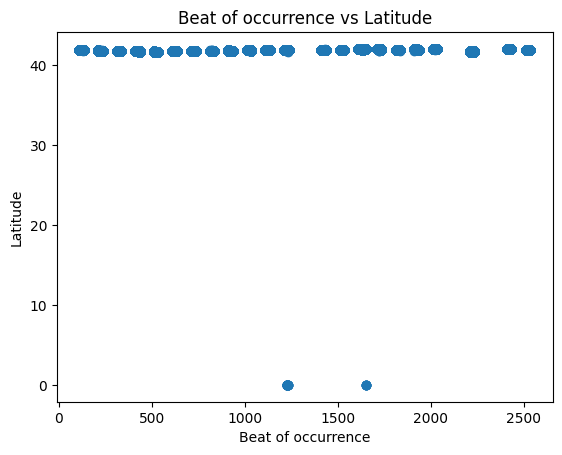

In [84]:
plt.scatter(crashes_df['BEAT_OF_OCCURRENCE'], crashes_df['LATITUDE'])
plt.xlabel('Beat of occurrence')
plt.ylabel('Latitude')
plt.title('Beat of occurrence vs Latitude')
plt.show()

Most values are above 40. `BEAT_OF_OCCURRENCE` doesn't help because the values don't change that much.

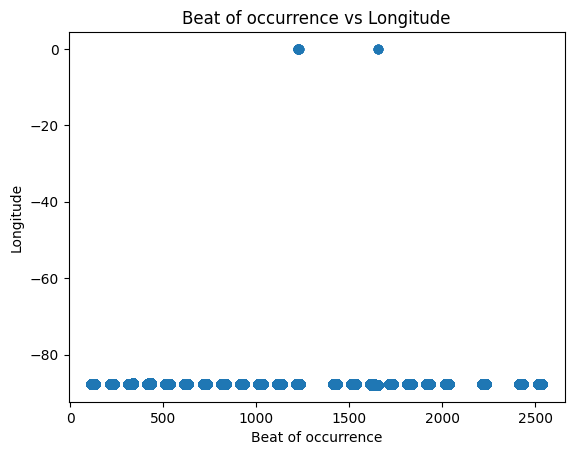

In [85]:
plt.scatter(crashes_df['BEAT_OF_OCCURRENCE'], crashes_df['LONGITUDE'])
plt.xlabel('Beat of occurrence')
plt.ylabel('Longitude')
plt.title('Beat of occurrence vs Longitude')
plt.show()

Same here.

In [86]:
crashes_df[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,818267.000000,818267.000000
mean,41.854908,-87.673596
std,0.335164,0.681035
min,0.000000,-87.936193
25%,41.782557,-87.721764
50%,41.874827,-87.674195
75%,41.924410,-87.633428
max,42.022780,0.000000


The values don't vary that much, so let's fill missing values with mean.

In [87]:
latitude_mean = crashes_df['LATITUDE'].mean()
longitude_mean = crashes_df['LONGITUDE'].mean()

crashes_df['LATITUDE'].fillna(value=latitude_mean, inplace=True)
crashes_df['LONGITUDE'].fillna(value=longitude_mean, inplace=True)

In [88]:
crashes_df[['LATITUDE', 'LONGITUDE']].isnull().sum()

LATITUDE     0
LONGITUDE    0
dtype: int64

In [89]:
crashes_df[['LATITUDE', 'LONGITUDE', 'LOCATION']][~crashes_df['LOCATION'].isna()].head()

,LATITUDE,LONGITUDE,LOCATION
1,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
13,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018)
14,41.899225,-87.696642,POINT (-87.696642374961 41.899224596015)
20,41.744152,-87.585945,POINT (-87.585945066953 41.744151639042)


In [90]:
def FillLocation(location, latitude, longitude):
  if pd.notnull(location):
    return location
  else:
    return f'POINT ({longitude} {latitude})'

In [91]:
crashes_df['LOCATION'] = crashes_df.apply(lambda x: FillLocation(x['LOCATION'], x['LATITUDE'], x['LONGITUDE']), axis=1)

In [92]:
crashes_df['LOCATION'].isnull().sum()

0

###### `TRAFFIC_CONTROL_DEVICE`

In [93]:
crashes_df['TRAFFIC_CONTROL_DEVICE'].unique()

array(['OTHER', 'TRAFFIC SIGNAL', 'NO CONTROLS', 'STOP SIGN/FLASHER',
       'UNKNOWN', 'OTHER WARNING SIGN', 'OTHER REG. SIGN', 'YIELD',
       'PEDESTRIAN CROSSING SIGN', 'LANE USE MARKING',
       'RAILROAD CROSSING GATE', 'FLASHING CONTROL SIGNAL', 'SCHOOL ZONE',
       'POLICE/FLAGMAN', 'DELINEATORS', 'OTHER RAILROAD CROSSING',
       'RR CROSSING SIGN', 'NO PASSING', 'BICYCLE CROSSING SIGN'],
      dtype=object)

We'll merge `UNKNOWN` & `OTHER` since they're the same.

In [94]:
crashes_df.loc[crashes_df['TRAFFIC_CONTROL_DEVICE'] == 'OTHER', 'TRAFFIC_CONTROL_DEVICE'] = 'UNKNOWN'

In [95]:
len(crashes_df.loc[crashes_df['TRAFFIC_CONTROL_DEVICE'] == 'UNKNOWN']) * 100 / len(crashes_df)

4.706556288738368

~5% is small. We'll replace `UNKNOWN` with most repeated label.

In [96]:
most_repeated_label = crashes_df['TRAFFIC_CONTROL_DEVICE'].value_counts().index.tolist()[0]

crashes_df.loc[crashes_df['TRAFFIC_CONTROL_DEVICE'] == 'UNKNOWN', 'TRAFFIC_CONTROL_DEVICE'] = most_repeated_label

###### `DEVICE_CONDITION`

In [97]:
crashes_df['DEVICE_CONDITION'].unique()

array(['FUNCTIONING PROPERLY', 'NO CONTROLS', 'FUNCTIONING IMPROPERLY',
       'UNKNOWN', 'OTHER', 'NOT FUNCTIONING', 'MISSING',
       'WORN REFLECTIVE MATERIAL'], dtype=object)

We'll merge `UNKNOWN`, `OTHER` & `MISSING`, since they're the same.

In [98]:
crashes_df.loc[crashes_df['DEVICE_CONDITION'] == 'OTHER', 'DEVICE_CONDITION'] = 'UNKNOWN'
crashes_df.loc[crashes_df['DEVICE_CONDITION'] == 'MISSING', 'DEVICE_CONDITION'] = 'UNKNOWN'

In [99]:
len(crashes_df.loc[crashes_df['DEVICE_CONDITION'] == 'UNKNOWN']) * 100 / len(crashes_df)

7.487890751580483

~7% is small. We'll replace `UNKNOWN` with most repeated label.

In [100]:
most_repeated_label = crashes_df['DEVICE_CONDITION'].value_counts().index.tolist()[0]

crashes_df.loc[crashes_df['DEVICE_CONDITION'] == 'UNKNOWN', 'DEVICE_CONDITION'] = most_repeated_label

###### `TRAFFICWAY_TYPE`

In [101]:
crashes_df['TRAFFICWAY_TYPE'].unique()

array(['OTHER', 'DIVIDED - W/MEDIAN (NOT RAISED)', 'NOT DIVIDED',
       'ONE-WAY', 'FOUR WAY', 'PARKING LOT', 'DIVIDED - W/MEDIAN BARRIER',
       'T-INTERSECTION', 'UNKNOWN', 'RAMP', 'ALLEY', 'DRIVEWAY',
       'UNKNOWN INTERSECTION TYPE', 'TRAFFIC ROUTE',
       'FIVE POINT, OR MORE', 'NOT REPORTED', 'CENTER TURN LANE',
       'L-INTERSECTION', 'Y-INTERSECTION', 'ROUNDABOUT'], dtype=object)

We'll merge `UNKNOWN`, `OTHER` & `NOT REPORTED`, since they're the same.

In [102]:
crashes_df.loc[crashes_df['TRAFFICWAY_TYPE'] == 'OTHER', 'TRAFFICWAY_TYPE'] = 'UNKNOWN'
crashes_df.loc[crashes_df['TRAFFICWAY_TYPE'] == 'NOT REPORTED', 'TRAFFICWAY_TYPE'] = 'UNKNOWN'

In [103]:
len(crashes_df.loc[crashes_df['TRAFFICWAY_TYPE'] == 'UNKNOWN']) * 100 / len(crashes_df)

3.9697459940263875

~4% is small. We'll replace `UNKNOWN` with most repeated label.

In [104]:
most_repeated_label = crashes_df['TRAFFICWAY_TYPE'].value_counts().index.tolist()[0]

crashes_df.loc[crashes_df['TRAFFICWAY_TYPE'] == 'UNKNOWN', 'TRAFFICWAY_TYPE'] = most_repeated_label

###### `ROAD_DEFECT`

In [105]:
crashes_df['ROAD_DEFECT'].unique()

array(['NO DEFECTS', 'UNKNOWN', 'DEBRIS ON ROADWAY', 'OTHER',
       'WORN SURFACE', 'SHOULDER DEFECT', 'RUT, HOLES'], dtype=object)

We'll merge `UNKNOWN` & `OTHER`, since they're the same.

In [106]:
crashes_df.loc[crashes_df['ROAD_DEFECT'] == 'OTHER', 'ROAD_DEFECT'] = 'UNKNOWN'

In [107]:
len(crashes_df.loc[crashes_df['ROAD_DEFECT'] == 'UNKNOWN']) * 100 / len(crashes_df)

18.274133237535455

We'll use `MultinomialNB` to fill `UNKNOWN` values.

In [108]:
selected_columns = ['ALIGNMENT', 'ROADWAY_SURFACE_COND']

known_defects = crashes_df[crashes_df['ROAD_DEFECT'] != 'UNKNOWN']
unknown_defects = crashes_df[crashes_df['ROAD_DEFECT'] == 'UNKNOWN']

combined_df = pd.concat([known_defects, unknown_defects])

encoded_df = pd.get_dummies(combined_df[selected_columns])

x = encoded_df.iloc[:len(known_defects), :].values
rows_with_missing_road_defect = encoded_df.iloc[len(known_defects):, :].values

encoder = LabelEncoder()
y = encoder.fit_transform(known_defects['ROAD_DEFECT'].values)

In [109]:
del known_defects, unknown_defects, combined_df, encoded_df

In [110]:
classifier = MultinomialNB()
classifier.fit(x, y)

MultinomialNB()

In [111]:
predictions = classifier.predict(rows_with_missing_road_defect)

In [112]:
crashes_df.loc[crashes_df['ROAD_DEFECT'] == 'UNKNOWN', 'ROAD_DEFECT'] = encoder.inverse_transform(predictions)

In [113]:
crashes_df['ROAD_DEFECT'].unique()

array(['NO DEFECTS', 'DEBRIS ON ROADWAY', 'WORN SURFACE',
       'SHOULDER DEFECT', 'RUT, HOLES'], dtype=object)

##### Solving conflicts

###### `CRASH_DATE` & `DATE_POLICE_NOTIFIED`

`CRASH_DATE` should be <= `DATE_POLICE_NOTIFIED` obviously.

In [114]:
def IsCrashDateSmaller(date1, date2):
  newdate1 = time.strptime(date1, "%m/%d/%Y %I:%M:%S %p")
  newdate2 = time.strptime(date2, "%m/%d/%Y %I:%M:%S %p")

  return newdate1 <= newdate2

In [115]:
crashes_df.loc[:, 'SMALLER'] = crashes_df.apply(lambda x: IsCrashDateSmaller(x['CRASH_DATE'], x['DATE_POLICE_NOTIFIED']), axis=1)

In [116]:
crashes_df[['CRASH_DATE', 'DATE_POLICE_NOTIFIED']].loc[crashes_df['SMALLER'] == False]

,CRASH_DATE,DATE_POLICE_NOTIFIED
441942,03/11/2018 03:58:00 AM,03/11/2018 03:01:00 AM


There's only one conflict.

In [117]:
crashes_df.loc[441942, 'CRASH_DATE'] = crashes_df.loc[441942, 'DATE_POLICE_NOTIFIED']

In [118]:
crashes_df[['CRASH_DATE', 'DATE_POLICE_NOTIFIED']].loc[crashes_df['SMALLER'] == False]

,CRASH_DATE,DATE_POLICE_NOTIFIED
441942,03/11/2018 03:01:00 AM,03/11/2018 03:01:00 AM


We can drop `DATE_POLICE_NOTIFIED` because there's no more conflicts anymore.

In [119]:
crashes_df.drop(['DATE_POLICE_NOTIFIED', 'SMALLER'], inplace=True, axis=1)

###### `CRASH_DATE` & (`CRASH_HOUR`, `CRASH_DAY_OF_WEEK` & `CRASH_MONTH`)

In [120]:
def CompareDateWithHour(date_str, hour):
  date = time.strptime(date_str, "%m/%d/%Y %I:%M:%S %p")
  return date.tm_hour == hour

def CompareDateWithMonth(date, month):
  date = time.strptime(date, "%m/%d/%Y %I:%M:%S %p")
  return date.tm_mon == month

def CompareDateWithDayOfWeek(date, day_of_week):
  date = time.strptime(date, "%m/%d/%Y %I:%M:%S %p")
  return date.tm_wday == day_of_week

In [121]:
crashes_df['Compare'] = crashes_df.apply(lambda x: CompareDateWithHour(x['CRASH_DATE'], x['CRASH_HOUR']), axis=1)
crashes_df['Compare'].value_counts()

True    823957
Name: Compare, dtype: int64

There's no conflicts.

In [122]:
crashes_df['Compare'] = crashes_df.apply(lambda x: CompareDateWithMonth(x['CRASH_DATE'], x['CRASH_MONTH']), axis=1)
crashes_df['Compare'].value_counts()

True    823957
Name: Compare, dtype: int64

There's no conflicts.

In [123]:
crashes_df['Compare'] = crashes_df.apply(lambda x: CompareDateWithDayOfWeek(x['CRASH_DATE'], x['CRASH_DAY_OF_WEEK']), axis=1)
crashes_df['Compare'].value_counts()

False    823957
Name: Compare, dtype: int64

All values are wrong. Let's correct them.

In [124]:
def ReturnDayOfWeek(date):
  date = time.strptime(date, "%m/%d/%Y %I:%M:%S %p")
  return date.tm_wday

In [125]:
crashes_df['CRASH_DAY_OF_WEEK'] = crashes_df.apply(lambda x: ReturnDayOfWeek(x['CRASH_DATE']), axis=1)

In [126]:
crashes_df['Compare'] = crashes_df.apply(lambda x: CompareDateWithDayOfWeek(x['CRASH_DATE'], x['CRASH_DAY_OF_WEEK']), axis=1)
crashes_df['Compare'].value_counts()

True    823957
Name: Compare, dtype: int64

In [127]:
crashes_df.drop('Compare', inplace=True, axis=1)

###### `CRASH_HOUR` & `LIGHTING_CONDITION`

Let's the minimum/maximum hour for each corresponding `LIGHTING_CONDITION` label.

In [128]:
for item in crashes_df['LIGHTING_CONDITION'].unique():
  tmp = crashes_df.loc[crashes_df['LIGHTING_CONDITION'] == item, 'CRASH_HOUR']
  print(f'LIGHTING_CONDITION: {item}\n', f'From: {tmp.min()}', f'To {tmp.max()}\n')

LIGHTING_CONDITION: DAYLIGHT
 From: 0 To 23

LIGHTING_CONDITION: DARKNESS, LIGHTED ROAD
 From: 0 To 23

LIGHTING_CONDITION: DARKNESS
 From: 0 To 23

LIGHTING_CONDITION: UNKNOWN
 From: 0 To 23

LIGHTING_CONDITION: DUSK
 From: 0 To 23

LIGHTING_CONDITION: DAWN
 From: 0 To 23



Look likes there are some conflicts. Let's recalculate `LIGHTING_CONDITION` using this [source](https://www.timeanddate.com/sun/usa/chicago).

Quoting from this [source](https://www.timeanddate.com/astronomy/different-types-twilight.html://):

> Several countries use this definition of civil twilight to make laws related to aviation, hunting, and the usage of headlights and street lamps.

We'll use civil twilight for calculating the average dusk/dawn time.

For each month, we'll calculate the average sunrise, sunset, dusk and dawn times. Then we'll take the average over the year. We'll use this formula:

$$ \text{average time} = \frac{{\text{max} - \text{min}}}{2} + \text{min} $$

In [129]:
def average(hour1, hour2):
    hour1 = time.strptime(hour1, "%H:%M")
    hour2 = time.strptime(hour2, "%H:%M")

    minutes1 = hour1.tm_hour * 60 + hour1.tm_min
    minutes2 = hour2.tm_hour * 60 + hour2.tm_min

    avg_minutes = abs(minutes1 - minutes2) / 2 + min(minutes1, minutes2)

    avg_hour = avg_minutes // 60
    avg_min = avg_minutes % 60

    return int(avg_hour)

In [130]:
mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

dawn_hour1 =    ["06:46", "06:33", '06:56', '06:04', '05:15', '04:44', '04:45', '05:13', '05:48', '06:20', '05:54', '06:28']
dawn_hour2 =    ["06:34", "05:58", '06:05', '05:17', '04:44', '04:40', '05:12', '05:47', '06:19', '06:53', '06:27', '06:46']

dusk_hour1 =    ["17:01", "17:34", '19:09', '19:44', '20:20', '20:53', '21:03', '20:39', '19:51', '18:58', '17:12', '16:50']
dusk_hour2 =    ["17:33", "18:08", '19:43', '20:19', '20:52', '21:04', '20:40', '19:53', '19:00', '18:14', '16:51', '17:01']

In [131]:
average_dawn, average_dusk = [], []

for i in range(12):
  res = average(dawn_hour1[i], dawn_hour2[i])
  print(f'Average dawn time in {mon[i]}: {res}')
  average_dawn.append(res)

print()

for i in range(12):
  res = average(dusk_hour1[i], dusk_hour2[i])
  print(f'Average dusk time in {mon[i]}: {res}')
  average_dusk.append(res)

Average dawn time in Jan: 6
Average dawn time in Feb: 6
Average dawn time in Mar: 6
Average dawn time in Apr: 5
Average dawn time in May: 4
Average dawn time in Jun: 4
Average dawn time in Jul: 4
Average dawn time in Aug: 5
Average dawn time in Sep: 6
Average dawn time in Oct: 6
Average dawn time in Nov: 6
Average dawn time in Dec: 6

Average dusk time in Jan: 17
Average dusk time in Feb: 17
Average dusk time in Mar: 19
Average dusk time in Apr: 20
Average dusk time in May: 20
Average dusk time in Jun: 20
Average dusk time in Jul: 20
Average dusk time in Aug: 20
Average dusk time in Sep: 19
Average dusk time in Oct: 18
Average dusk time in Nov: 17
Average dusk time in Dec: 16


In [132]:
for i in range(12):
  print(f'For {mon[i]}:')
  print(f'Daylight: from {average_dawn[i] + 1} to {average_dusk[i] - 1}')
  print(f'Darkness: from {average_dusk[i] + 1} to {average_dawn[i] - 1}')
  print(f'Dawn: {average_dawn[i]}')
  print(f'Dusk: {average_dusk[i]}')
  print()

For Jan:
Daylight: from 7 to 16
Darkness: from 18 to 5
Dawn: 6
Dusk: 17

For Feb:
Daylight: from 7 to 16
Darkness: from 18 to 5
Dawn: 6
Dusk: 17

For Mar:
Daylight: from 7 to 18
Darkness: from 20 to 5
Dawn: 6
Dusk: 19

For Apr:
Daylight: from 6 to 19
Darkness: from 21 to 4
Dawn: 5
Dusk: 20

For May:
Daylight: from 5 to 19
Darkness: from 21 to 3
Dawn: 4
Dusk: 20

For Jun:
Daylight: from 5 to 19
Darkness: from 21 to 3
Dawn: 4
Dusk: 20

For Jul:
Daylight: from 5 to 19
Darkness: from 21 to 3
Dawn: 4
Dusk: 20

For Aug:
Daylight: from 6 to 19
Darkness: from 21 to 4
Dawn: 5
Dusk: 20

For Sep:
Daylight: from 7 to 18
Darkness: from 20 to 5
Dawn: 6
Dusk: 19

For Oct:
Daylight: from 7 to 17
Darkness: from 19 to 5
Dawn: 6
Dusk: 18

For Nov:
Daylight: from 7 to 16
Darkness: from 18 to 5
Dawn: 6
Dusk: 17

For Dec:
Daylight: from 7 to 15
Darkness: from 17 to 5
Dawn: 6
Dusk: 16



In [133]:
def CorrectLightingCondition(hour, light_condition, month):
  month -= 1

  if hour >= average_dawn[month] + 1 and hour <= average_dusk[month] - 1:
    return 'DAYLIGHT'

  elif hour >= average_dusk[month] + 1 or hour <= average_dawn[month] - 1:
    if light_condition == 'DARKNESS, LIGHTED ROAD':
      return 'DARKNESS, LIGHTED ROAD'
    else:
      return 'DARKNESS'

  elif hour == average_dawn[month]:
    return 'DAWN'

  elif hour == average_dusk[month]:
    return 'DUSK'

In [134]:
crashes_df['LIGHTING_CONDITION'].unique()

array(['DAYLIGHT', 'DARKNESS, LIGHTED ROAD', 'DARKNESS', 'UNKNOWN',
       'DUSK', 'DAWN'], dtype=object)

In [135]:
crashes_df['LIGHTING_CONDITION'] = crashes_df.apply(lambda x: CorrectLightingCondition(x['CRASH_HOUR'], x['LIGHTING_CONDITION'], x['CRASH_MONTH']), axis=1)

In [136]:
crashes_df['LIGHTING_CONDITION'].unique()

array(['DAYLIGHT', 'DUSK', 'DARKNESS, LIGHTED ROAD', 'DARKNESS', 'DAWN'],
      dtype=object)

We eliminated `UNKNOWN`.

###### `WEATHER_CONDITION` & `ROADWAY_SURFACE_COND`

For each `WEATHER_CONDITION`, let's print their `ROADWAY_SURFACE_COND`.

In [137]:
unique_weather_labels = crashes_df['WEATHER_CONDITION'].unique()

for item in unique_weather_labels:
  unique_surface_cond = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == item].unique()

  print(f'WEATHER_CONDITION: {item}')
  print(f'ROADWAY_SURFACE_COND: {unique_surface_cond}\n')

WEATHER_CONDITION: CLEAR
ROADWAY_SURFACE_COND: ['DRY' 'UNKNOWN' 'SNOW OR SLUSH' 'OTHER' 'WET' 'ICE' 'SAND, MUD, DIRT']

WEATHER_CONDITION: SNOW
ROADWAY_SURFACE_COND: ['SNOW OR SLUSH' 'WET' 'ICE' 'DRY' 'UNKNOWN' 'OTHER' 'SAND, MUD, DIRT']

WEATHER_CONDITION: UNKNOWN
ROADWAY_SURFACE_COND: ['UNKNOWN' 'DRY' 'OTHER' 'WET' 'SNOW OR SLUSH' 'ICE' 'SAND, MUD, DIRT']

WEATHER_CONDITION: RAIN
ROADWAY_SURFACE_COND: ['WET' 'DRY' 'UNKNOWN' 'SNOW OR SLUSH' 'ICE' 'OTHER' 'SAND, MUD, DIRT']

WEATHER_CONDITION: CLOUDY/OVERCAST
ROADWAY_SURFACE_COND: ['DRY' 'WET' 'UNKNOWN' 'OTHER' 'SNOW OR SLUSH' 'SAND, MUD, DIRT' 'ICE']

WEATHER_CONDITION: FOG/SMOKE/HAZE
ROADWAY_SURFACE_COND: ['WET' 'DRY' 'UNKNOWN' 'SNOW OR SLUSH' 'ICE' 'OTHER']

WEATHER_CONDITION: BLOWING SNOW
ROADWAY_SURFACE_COND: ['SNOW OR SLUSH' 'WET' 'OTHER' 'ICE' 'DRY' 'UNKNOWN']

WEATHER_CONDITION: FREEZING RAIN/DRIZZLE
ROADWAY_SURFACE_COND: ['WET' 'DRY' 'SNOW OR SLUSH' 'ICE' 'UNKNOWN' 'OTHER']

WEATHER_CONDITION: OTHER
ROADWAY_SURFACE_COND: ['WET

Let's replace `DRY` in `SNOW` with most repeated label.

In [138]:
weather = 'SNOW'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `DRY` & `ICE` in `RAIN` with most repeated label.

In [139]:
weather = 'RAIN'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'ICE'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `DRY` in `BLOWING SNOW` with most repeated label.

In [140]:
weather = 'BLOWING SNOW'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `DRY` in `FREEZING RAIN/DRIZZLE` with most repeated label.

In [141]:
weather = 'FREEZING RAIN/DRIZZLE'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `DRY` in `SLEET/HAIL` with most repeated label.

In [142]:
weather = 'SLEET/HAIL'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `DRY` in `BLOWING SAND, SOIL, DIRT` with most repeated label.

In [143]:
weather = 'BLOWING SAND, SOIL, DIRT'

most_repeated_label = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == weather].value_counts().index.tolist()[0]
crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == weather) & (crashes_df['ROADWAY_SURFACE_COND'] == 'DRY'), "ROADWAY_SURFACE_COND"] = most_repeated_label

Let's replace `OTHER` in `WEATHER_CONDITION` & `ROADWAY_SURFACE_COND` with `UNKNOWN`.

In [144]:
crashes_df.loc[crashes_df['WEATHER_CONDITION'] == 'OTHER', 'WEATHER_CONDITION'] = 'UNKNOWN'
crashes_df.loc[crashes_df['ROADWAY_SURFACE_COND'] == 'OTHER', 'ROADWAY_SURFACE_COND'] = 'UNKNOWN'

Each `WEATHER_CONDITION` has `UNKNOWN` `ROADWAY_SURFACE_COND`. Let's replace it with the most repeated label.

In [145]:
unique_weather_labels = crashes_df['WEATHER_CONDITION'].unique()

for item in unique_weather_labels:
  most_repeated_surface_cond = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == item].value_counts().index.tolist()[0]

  print(f'WEATHER_CONDITION: {item}')
  print(f'Most repeated surface condition: {most_repeated_surface_cond}')
  print(f'Replace UNKNOWN surface condition with {most_repeated_surface_cond}')
  print()

  crashes_df.loc[(crashes_df["WEATHER_CONDITION"] == item) & (crashes_df["ROADWAY_SURFACE_COND"] == 'UNKNOWN'), "ROADWAY_SURFACE_COND"] = most_repeated_surface_cond

WEATHER_CONDITION: CLEAR
Most repeated surface condition: DRY
Replace UNKNOWN surface condition with DRY

WEATHER_CONDITION: SNOW
Most repeated surface condition: SNOW OR SLUSH
Replace UNKNOWN surface condition with SNOW OR SLUSH

WEATHER_CONDITION: UNKNOWN
Most repeated surface condition: UNKNOWN
Replace UNKNOWN surface condition with UNKNOWN

WEATHER_CONDITION: RAIN
Most repeated surface condition: WET
Replace UNKNOWN surface condition with WET

WEATHER_CONDITION: CLOUDY/OVERCAST
Most repeated surface condition: DRY
Replace UNKNOWN surface condition with DRY

WEATHER_CONDITION: FOG/SMOKE/HAZE
Most repeated surface condition: WET
Replace UNKNOWN surface condition with WET

WEATHER_CONDITION: BLOWING SNOW
Most repeated surface condition: SNOW OR SLUSH
Replace UNKNOWN surface condition with SNOW OR SLUSH

WEATHER_CONDITION: FREEZING RAIN/DRIZZLE
Most repeated surface condition: WET
Replace UNKNOWN surface condition with WET

WEATHER_CONDITION: SEVERE CROSS WIND GATE
Most repeated surfac

`UNKNOWN` in `WEATHER_CONDITION` has a lot of `ROADWAY_SURFACE_COND` other than `UNKNOWN`. Let's replace them with their most repeated weather.

In [146]:
unique_surface_cond_labels = crashes_df['ROADWAY_SURFACE_COND'].loc[crashes_df['WEATHER_CONDITION'] == 'UNKNOWN'].unique()

for item in unique_surface_cond_labels:
  most_repeated_weather = crashes_df['WEATHER_CONDITION'].loc[crashes_df['ROADWAY_SURFACE_COND'] == item].value_counts().index.tolist()[0]

  print(f'ROADWAY_SURFACE_COND: {item}')
  print(f'Most repeated weather: {most_repeated_weather}')
  print(f'Replace UNKNOWN weather condition with {most_repeated_weather}')
  print()

  crashes_df.loc[(crashes_df['WEATHER_CONDITION'] == 'UNKNOWN') & (crashes_df['ROADWAY_SURFACE_COND'] == item), 'WEATHER_CONDITION'] = most_repeated_weather

ROADWAY_SURFACE_COND: UNKNOWN
Most repeated weather: UNKNOWN
Replace UNKNOWN weather condition with UNKNOWN

ROADWAY_SURFACE_COND: DRY
Most repeated weather: CLEAR
Replace UNKNOWN weather condition with CLEAR

ROADWAY_SURFACE_COND: WET
Most repeated weather: RAIN
Replace UNKNOWN weather condition with RAIN

ROADWAY_SURFACE_COND: SNOW OR SLUSH
Most repeated weather: SNOW
Replace UNKNOWN weather condition with SNOW

ROADWAY_SURFACE_COND: ICE
Most repeated weather: CLEAR
Replace UNKNOWN weather condition with CLEAR

ROADWAY_SURFACE_COND: SAND, MUD, DIRT
Most repeated weather: CLEAR
Replace UNKNOWN weather condition with CLEAR



Let's replace `UNKNOWN` in `WEATHER_CONDITION` & `ROADWAY_SURFACE_COND` with most repeated `WEATHER_CONDITION` & `ROADWAY_SURFACE_COND`, respectively.

In [147]:
most_repeated_weather = crashes_df['WEATHER_CONDITION'].value_counts().index.tolist()[0]
most_repeated_surface_cond = crashes_df['ROADWAY_SURFACE_COND'].value_counts().index.tolist()[0]

crashes_df.loc[crashes_df['WEATHER_CONDITION'] == 'UNKNOWN', 'WEATHER_CONDITION'] = most_repeated_weather
crashes_df.loc[crashes_df['ROADWAY_SURFACE_COND'] == 'UNKNOWN', 'ROADWAY_SURFACE_COND'] = most_repeated_surface_cond

In [148]:
unique_weather_labels = crashes_df['WEATHER_CONDITION'].unique()

for item in unique_weather_labels:
  unique_surface_cond = crashes_df["ROADWAY_SURFACE_COND"].loc[crashes_df["WEATHER_CONDITION"] == item].unique()

  print(f'WEATHER_CONDITION: {item}')
  print(f'ROADWAY_SURFACE_COND: {unique_surface_cond}\n')

WEATHER_CONDITION: CLEAR
ROADWAY_SURFACE_COND: ['DRY' 'SNOW OR SLUSH' 'WET' 'ICE' 'SAND, MUD, DIRT']

WEATHER_CONDITION: SNOW
ROADWAY_SURFACE_COND: ['SNOW OR SLUSH' 'WET' 'ICE' 'SAND, MUD, DIRT']

WEATHER_CONDITION: RAIN
ROADWAY_SURFACE_COND: ['WET' 'SNOW OR SLUSH' 'SAND, MUD, DIRT']

WEATHER_CONDITION: CLOUDY/OVERCAST
ROADWAY_SURFACE_COND: ['DRY' 'WET' 'SNOW OR SLUSH' 'SAND, MUD, DIRT' 'ICE']

WEATHER_CONDITION: FOG/SMOKE/HAZE
ROADWAY_SURFACE_COND: ['WET' 'DRY' 'SNOW OR SLUSH' 'ICE']

WEATHER_CONDITION: BLOWING SNOW
ROADWAY_SURFACE_COND: ['SNOW OR SLUSH' 'WET' 'ICE']

WEATHER_CONDITION: FREEZING RAIN/DRIZZLE
ROADWAY_SURFACE_COND: ['WET' 'SNOW OR SLUSH' 'ICE']

WEATHER_CONDITION: SEVERE CROSS WIND GATE
ROADWAY_SURFACE_COND: ['WET' 'DRY' 'SNOW OR SLUSH' 'ICE']

WEATHER_CONDITION: SLEET/HAIL
ROADWAY_SURFACE_COND: ['WET' 'ICE' 'SNOW OR SLUSH']

WEATHER_CONDITION: BLOWING SAND, SOIL, DIRT
ROADWAY_SURFACE_COND: ['DRY' 'SAND, MUD, DIRT']



##### Outlier/noise detection

###### `POSTED_SPEED_LIMIT`

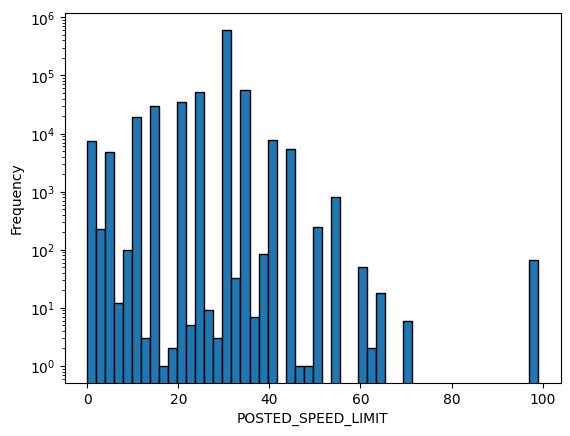

In [149]:
plt.hist(crashes_df['POSTED_SPEED_LIMIT'], bins=50, edgecolor='black')
plt.xlabel('POSTED_SPEED_LIMIT')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In US, miles per hour is used instead of kilometer per hour. Everything below 30 is noise.

In [150]:
len(crashes_df[crashes_df['POSTED_SPEED_LIMIT'] < 30]) * 100 / len(crashes_df)

17.934431044338478

In [151]:
len(crashes_df[crashes_df['POSTED_SPEED_LIMIT'] > 30]) * 100 / len(crashes_df)

8.459664764059289

In [152]:
crashes_df['POSTED_SPEED_LIMIT'].describe()

count    823957.000000
mean         28.407031
std           6.161584
min           0.000000
25%          30.000000
50%          30.000000
75%          30.000000
max          99.000000
Name: POSTED_SPEED_LIMIT, dtype: float64

In [153]:
small_mean = crashes_df['POSTED_SPEED_LIMIT'][crashes_df['POSTED_SPEED_LIMIT'] < 30].mean()
small_mean

17.94209322469751

In [154]:
big_mean = crashes_df['POSTED_SPEED_LIMIT'][crashes_df['POSTED_SPEED_LIMIT'] > 40].mean()
big_mean

47.12750373692078

In [155]:
crashes_df['POSTED_SPEED_LIMIT'][crashes_df['POSTED_SPEED_LIMIT'] < 30] = small_mean
crashes_df['POSTED_SPEED_LIMIT'][crashes_df['POSTED_SPEED_LIMIT'] > 40] = big_mean

In [156]:
crashes_df['POSTED_SPEED_LIMIT'].describe()

count    823957.000000
mean         28.407031
std           5.343560
min          17.942093
25%          30.000000
50%          30.000000
75%          30.000000
max          47.127504
Name: POSTED_SPEED_LIMIT, dtype: float64

###### `LATITUDE`, `LONGITUDE` & `LOCATION`

In [157]:
crashes_df[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,823957.000000,823957.000000
mean,41.854908,-87.673596
std,0.334004,0.678680
min,0.000000,-87.936193
25%,41.783381,-87.721438
50%,41.874311,-87.673608
75%,41.924200,-87.633778
max,42.022780,0.000000


In [158]:
len(crashes_df[crashes_df['LATITUDE'] < 40])

49

In [159]:
len(crashes_df[crashes_df['LONGITUDE'] > -80])

49

In [160]:
crashes_df[['LATITUDE', 'LONGITUDE']][(crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)].value_counts()

LATITUDE  LONGITUDE
0.0       0.0          49
dtype: int64

According to this [source](https://en.wikipedia.org/wiki/Null_Island), 0 latitude & 0 longitude is the location of Null island. Let's see if these coordinates represents a place in Chicago using `STREET_NAME`.

In [161]:
crashes_df['STREET_NAME'][(crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)].unique()

array(['DAMEN AVE', 'IRVING PARK RD'], dtype=object)

According to this [source](https://en.wikipedia.org/wiki/Damen_Avenue), `DAMEN AVE` is a street in Chicago.

According to this [source](https://en.wikipedia.org/wiki/Irving_Park,_Chicago), `IRVING PARK RD` is a street in Chicago.

Let's find their latitude and longitude.

According to [this](https://latlong.info/united-states/illinois/irving-park), IRVING PARK RD is at Latitude: 41.95336000, Longitude: -87.73645000.

In [162]:
crashes_df['LATITUDE'][(crashes_df['STREET_NAME'] == 'IRVING PARK RD') & (crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)] = 41.95336000
crashes_df['LONGITUDE'][(crashes_df['STREET_NAME'] == 'IRVING PARK RD') & (crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)] = -87.73645000

We used this [website](https://reviewsonmywebsite.com/google-review-link-generator) to retrieve a bussiness place id in `DAMEN AVE`. The id is `ChIJzcP2AEHTD4gR11W716P1jNI`.

Then, we used API on this [website](https://developers.google.com/maps/documentation/places/web-service/place-details?apix_params=%7B%22name%22%3A%22places%2FChIJzcP2AEHTD4gR11W716P1jNI%22%2C%22fields%22%3A%22*%22%7D) to retrieve the latitude and longitutde of this street.

Latitude: 41.9280185. Longitude: -87.678118599999991.

In [163]:
crashes_df['LATITUDE'][(crashes_df['STREET_NAME'] == 'DAMEN AVE') & (crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)] = 41.9280185
crashes_df['LONGITUDE'][(crashes_df['STREET_NAME'] == 'DAMEN AVE') & (crashes_df['LATITUDE'] < 40) & (crashes_df['LONGITUDE'] > -80)] =  -87.678118599999991

In [164]:
crashes_df[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,823957.000000,823957.000000
mean,41.857402,-87.673596
std,0.085866,0.678680
min,41.644670,-87.936193
25%,41.783402,-87.721438
50%,41.874315,-87.673608
75%,41.924213,-87.633778
max,42.022780,0.000000


In [165]:
def FillLocation(latitude, longitude):
  return f'POINT ({longitude} {latitude})'

In [166]:
crashes_df['LOCATION'] = crashes_df.apply(lambda x: FillLocation(x['LATITUDE'], x['LONGITUDE']), axis=1)

#### Vehicles

In [167]:
vehicles_df.loc[vehicles_df['UNIT_TYPE'].isna()].head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,AREA_01_I,FIRST_CONTACT_POINT
158,1000050,f59f115cb6eda57e929debe2c17026ca17bce6ad0d9842...,11/18/2020 07:20:00 PM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,1000280,e2dab91401d3ed94e24168fcc1a16840555e8e791e1886...,11/25/2020 08:07:00 PM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,1000867,05019b93a9430d2dc8f0da08e85159be692f20b4a9c2e9...,11/27/2020 11:15:00 PM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,1001417,52a209c3ac469144dbd4c16745c85255138f09dfb96790...,11/28/2020 02:06:00 PM,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942,100176,06acd9c4a9dd5873ed832d5f37854c7d5c5d63a49a12c7...,11/22/2016 05:00:00 PM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From what we can see in the previous PPScore, it seems that whenever `UNIT_TYPE` == NaN then `OCCUPANT_CNT` and `MANEUVER` are also NaN but let's check that assumption.

In [168]:
def are_all_nan_if_x_is_nan(col_name, label):
  rows = vehicles_df[vehicles_df[label].isna()]
  are_all_nan = rows[col_name].isna().all()
  print(f'Are all values in {col_name} NaN where {label} is NaN? {are_all_nan}')

In [169]:
are_all_nan_if_x_is_nan('OCCUPANT_CNT', 'UNIT_TYPE')
are_all_nan_if_x_is_nan('MANEUVER', 'UNIT_TYPE')

Are all values in OCCUPANT_CNT NaN where UNIT_TYPE is NaN? False
Are all values in MANEUVER NaN where UNIT_TYPE is NaN? False


It seems that our assumption is false, so let's try a different approach. We'll count the rows where `UNIT_TYPE` is NaN but both `OCCUPANT_CNT` and `MANEUVER` are not.

In [170]:
nan_unit_type = vehicles_df.loc[(vehicles_df['UNIT_TYPE'].isna()) & (vehicles_df['OCCUPANT_CNT'].notna()) & (vehicles_df['MANEUVER'].notna())]
len(nan_unit_type)

19

The following code analyzes the `vehicles_df` to see how the `UNIT_TYPE` varies with different combinations of `OCCUPANT_CNT` and `MANEUVER` values. This is useful for exploring the relationships between these three variables in the our data.

In [171]:
filtered_df = vehicles_df[vehicles_df['UNIT_TYPE'].isna() & vehicles_df['OCCUPANT_CNT'].notna() & vehicles_df['MANEUVER'].notna()]

combinations = filtered_df[['OCCUPANT_CNT', 'MANEUVER']].drop_duplicates()

for _, row in combinations.iterrows():
  occ_cnt = row['OCCUPANT_CNT']
  maneuver = row['MANEUVER']
  combo_df = vehicles_df[(vehicles_df['OCCUPANT_CNT'] == occ_cnt) & (vehicles_df['MANEUVER'] == maneuver)]
  unit_type_counts = combo_df['UNIT_TYPE'].value_counts()
  print(f"For OCCUPANT_CNT = {occ_cnt} and MANEUVER = {maneuver}, the counts for each UNIT_TYPE are:")
  print(unit_type_counts)


For OCCUPANT_CNT = 2.0 and MANEUVER = STRAIGHT AHEAD, the counts for each UNIT_TYPE are:
DRIVER                 91679
DRIVERLESS                19
PARKED                     4
NON-CONTACT VEHICLE        3
DISABLED VEHICLE           1
Name: UNIT_TYPE, dtype: int64
For OCCUPANT_CNT = 1.0 and MANEUVER = STRAIGHT AHEAD, the counts for each UNIT_TYPE are:
DRIVER                 624251
NON-CONTACT VEHICLE        48
DRIVERLESS                 37
PARKED                      6
DISABLED VEHICLE            4
Name: UNIT_TYPE, dtype: int64
For OCCUPANT_CNT = 1.0 and MANEUVER = AVOIDING VEHICLES/OBJECTS, the counts for each UNIT_TYPE are:
DRIVER                 5551
NON-CONTACT VEHICLE       3
Name: UNIT_TYPE, dtype: int64
For OCCUPANT_CNT = 0.0 and MANEUVER = UNKNOWN/NA, the counts for each UNIT_TYPE are:
DRIVERLESS             752
PARKED                 578
DRIVER                   7
NON-CONTACT VEHICLE      2
DISABLED VEHICLE         2
Name: UNIT_TYPE, dtype: int64
For OCCUPANT_CNT = 1.0 and MANE

In each pair, one value shows up a lot more than the others. Since we only have 19 missing values, we can fill them in with the value that is the most common in each pair.

In [172]:
filtered_df = vehicles_df[vehicles_df['UNIT_TYPE'].isna() & vehicles_df['OCCUPANT_CNT'].notna() & vehicles_df['MANEUVER'].notna()]

combinations = filtered_df[['OCCUPANT_CNT', 'MANEUVER']].drop_duplicates()

for _, row in combinations.iterrows():
    occ_cnt = row['OCCUPANT_CNT']
    maneuver = row['MANEUVER']
    combo_df = vehicles_df[(vehicles_df['OCCUPANT_CNT'] == occ_cnt) & (vehicles_df['MANEUVER'] == maneuver)]
    most_common_unit_type = combo_df['UNIT_TYPE'].mode().iloc[0] if not combo_df['UNIT_TYPE'].mode().empty else combo_df['UNIT_TYPE'].mode()[0]
    vehicles_df.loc[(vehicles_df['UNIT_TYPE'].isna()) & (vehicles_df['OCCUPANT_CNT'] == occ_cnt) & (vehicles_df['MANEUVER'] == maneuver), 'UNIT_TYPE'] = most_common_unit_type


In [173]:
are_all_nan_if_x_is_nan('OCCUPANT_CNT', 'UNIT_TYPE')
are_all_nan_if_x_is_nan('MANEUVER', 'UNIT_TYPE')

Are all values in OCCUPANT_CNT NaN where UNIT_TYPE is NaN? True
Are all values in MANEUVER NaN where UNIT_TYPE is NaN? True


The identified correlation proved valuable in imputing some missing values within the `UNIT_TYPE` field. We should now investigate the feasibility of either imputing or removing the remaining missing data points.

In [174]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                   2131                  0
VEHICLE_ID                 38473                  2
MAKE                       38478                  2
MODEL                      38623                  2
LIC_PLATE_STATE           188917                 11
VEHICLE_YEAR              301958                 18
VEHICLE_DEFECT             38473                  2
VEHICLE_TYPE               38473                  2
VEHICLE_USE                38473                  2
TRAVEL_DIRECTION           38473                  2
MANEUVER                   38473                  2
OCCUPANT_CNT               38473                  2
AREA_01_I                1231298                 73
FIRST_CONTACT_POINT        41596                  2


In [175]:
cols_names = ["UNIT_TYPE", "VEHICLE_ID", "MAKE", "MODEL", "VEHICLE_YEAR", "VEHICLE_DEFECT", "VEHICLE_TYPE", "VEHICLE_USE", "TRAVEL_DIRECTION"]
for col in cols_names:
  are_all_nan_if_x_is_nan(col, 'UNIT_TYPE')

Are all values in UNIT_TYPE NaN where UNIT_TYPE is NaN? True
Are all values in VEHICLE_ID NaN where UNIT_TYPE is NaN? True
Are all values in MAKE NaN where UNIT_TYPE is NaN? True
Are all values in MODEL NaN where UNIT_TYPE is NaN? True
Are all values in VEHICLE_YEAR NaN where UNIT_TYPE is NaN? True
Are all values in VEHICLE_DEFECT NaN where UNIT_TYPE is NaN? True
Are all values in VEHICLE_TYPE NaN where UNIT_TYPE is NaN? True
Are all values in VEHICLE_USE NaN where UNIT_TYPE is NaN? True
Are all values in TRAVEL_DIRECTION NaN where UNIT_TYPE is NaN? True


Since all remaining values are missing (NaN) whenever the
UNIT_TYPE field is missing, it is not possible to estimate these values. Therefore, these rows (where UNIT_TYPE is NaN) will be removed.

In [176]:
vehicles_df = vehicles_df[vehicles_df["UNIT_TYPE"].notna()]

In [177]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                 36342                  2
MAKE                       36347                  2
MODEL                      36492                  2
LIC_PLATE_STATE           186786                 11
VEHICLE_YEAR              299827                 18
VEHICLE_DEFECT             36342                  2
VEHICLE_TYPE               36342                  2
VEHICLE_USE                36342                  2
TRAVEL_DIRECTION           36342                  2
MANEUVER                   36342                  2
OCCUPANT_CNT               36342                  2
AREA_01_I                1229167                 73
FIRST_CONTACT_POINT        39465                  2


We notice that the number of missing values (NaN) across
`VEHICLE_ID`, `VEHICLE_DEFECT`, `VEHICLE_TYPE`, and other fields appears consistent. This suggests a possible correlation, where a missing `VEHICLE_ID` may indicate missing values in other fields. But, we will verify this assumption.

In [178]:
cols_names = [ "VEHICLE_DEFECT", "VEHICLE_TYPE", "VEHICLE_USE", "TRAVEL_DIRECTION", "MANEUVER", "OCCUPANT_CNT"]
for col in cols_names:
  are_all_nan_if_x_is_nan(col, 'VEHICLE_ID')

Are all values in VEHICLE_DEFECT NaN where VEHICLE_ID is NaN? True
Are all values in VEHICLE_TYPE NaN where VEHICLE_ID is NaN? True
Are all values in VEHICLE_USE NaN where VEHICLE_ID is NaN? True
Are all values in TRAVEL_DIRECTION NaN where VEHICLE_ID is NaN? True
Are all values in MANEUVER NaN where VEHICLE_ID is NaN? True
Are all values in OCCUPANT_CNT NaN where VEHICLE_ID is NaN? True


And our assumptin is ture! Hence, we will drop rows where `VEHICLE_ID` == NaN.

In [179]:
vehicles_df = vehicles_df[vehicles_df["VEHICLE_ID"].notna()]

In [180]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                     0                  0
MAKE                           5                  0
MODEL                        150                  0
LIC_PLATE_STATE           150444                  9
VEHICLE_YEAR              263485                 16
VEHICLE_DEFECT                 0                  0
VEHICLE_TYPE                   0                  0
VEHICLE_USE                    0                  0
TRAVEL_DIRECTION               0                  0
MANEUVER                       0                  0
OCCUPANT_CNT                   0                  0
AREA_01_I                1192825                 73
FIRST_CONTACT_POINT         3123                  0


Let's now move on to `MAKE` and `MODEL` columns. We will run a similar test to the one we did before and see the results.

In [181]:
filtered_df = vehicles_df[vehicles_df['MAKE'].isna() & vehicles_df['MODEL'].notna()]

combinations = filtered_df[['MODEL']].drop_duplicates()

for _, row in combinations.iterrows():
    model = row['MODEL']
    combo_df = vehicles_df[(vehicles_df['MODEL'] == model)]
    unit_type_counts = combo_df['MAKE'].value_counts()
    print(f"For MODEL = {model}, the counts for each MAKE are:")
    print(unit_type_counts)

For MODEL = RDX, the counts for each MAKE are:
ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)    361
Name: MAKE, dtype: int64
For MODEL = TL, the counts for each MAKE are:
ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)    563
Name: MAKE, dtype: int64
For MODEL = MDX, the counts for each MAKE are:
ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)    828
Name: MAKE, dtype: int64
For MODEL = TSX, the counts for each MAKE are:
ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)    259
Name: MAKE, dtype: int64


Further analysis is unnecessary. The prior test identified a single, valid value for `MAKE`. This value is both the most common and the correct data point.

In [182]:
filtered_df = vehicles_df[vehicles_df['MAKE'].isna() & vehicles_df['MODEL'].notna()]

combinations = filtered_df[['MODEL']].drop_duplicates()

for _, row in combinations.iterrows():
    model = row['MODEL']
    combo_df = vehicles_df[(vehicles_df['MODEL'] == model)]
    most_common_unit_type = combo_df['MAKE'].mode().iloc[0] if not combo_df['MAKE'].mode().empty else combo_df['UNIT_TYPE'].mode()[0]
    vehicles_df.loc[(vehicles_df['MAKE'].isna()) & (vehicles_df['MODEL'] == model)] = most_common_unit_type


In [183]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                     0                  0
MAKE                           1                  0
MODEL                        150                  0
LIC_PLATE_STATE           150444                  9
VEHICLE_YEAR              263485                 16
VEHICLE_DEFECT                 0                  0
VEHICLE_TYPE                   0                  0
VEHICLE_USE                    0                  0
TRAVEL_DIRECTION               0                  0
MANEUVER                       0                  0
OCCUPANT_CNT                   0                  0
AREA_01_I                1192822                 73
FIRST_CONTACT_POINT         3123                  0


In [184]:
vehicles_df.loc[vehicles_df['MAKE'].isna()].head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,AREA_01_I,FIRST_CONTACT_POINT
1484356,857707,d9d33f7ce553831bca6d5d6f9927104587f61d0e56f9af...,03/07/2020 12:30:00 PM,1,DRIVER,813873.0,NaN,NaN,IL,2010.0,UNKNOWN,PASSENGER,UNKNOWN/NA,N,PASSING/OVERTAKING,1.0,Y,FRONT-RIGHT-CORNER


The final row containing a missing value in the `MAKE` field also has a missing value in the dependent field `MODEL`. Due to the difficulty of accurately imputing this missing value in this context, this row will be removed.

For the remaining missing values in the `MODEL` field (149 instances), the most frequent `MAKE` value will be used to impute these missing entries."

In [185]:
vehicles_df = vehicles_df[vehicles_df['MAKE'].notna()]

In [186]:
filtered_df = vehicles_df[vehicles_df['MODEL'].isna() & vehicles_df['MAKE'].notna()]

combinations = filtered_df[['MAKE']].drop_duplicates()

for _, row in combinations.iterrows():
    make = row['MAKE']
    combo_df = vehicles_df[(vehicles_df['MAKE'] == make)]
    most_common_unit_type = combo_df['MODEL'].mode().iloc[0] if not combo_df['MODEL'].mode().empty else 'Unknown'
    vehicles_df.loc[(vehicles_df['MODEL'].isna()) & (vehicles_df['MAKE'] == make)] = most_common_unit_type

In [187]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                     0                  0
MAKE                           0                  0
MODEL                          0                  0
LIC_PLATE_STATE           150434                  9
VEHICLE_YEAR              263472                 16
VEHICLE_DEFECT                 0                  0
VEHICLE_TYPE                   0                  0
VEHICLE_USE                    0                  0
TRAVEL_DIRECTION               0                  0
MANEUVER                       0                  0
OCCUPANT_CNT                   0                  0
AREA_01_I                1192720                 73
FIRST_CONTACT_POINT         3123                  0


However, there are instances of 'UNKNOWN' within the `MAKE` and `MODEL` fields. These values might be important for future imputation of the `VEHICLE_YEAR` field (More on that later). We will prioritize investigating these values first.

In [188]:
vehicles_df['MODEL'].unique()

array(['SENTRA', 'SEBRING', 'OUTBACK', ..., 'SONNET',
       'ONEIDA COACH MFG., GRAND LEDGE, MI',
       'HATFIELD WELDING & TRAILER SALES, INC. MT.PLEASANT'], dtype=object)

In [189]:
def show_unknown_values(percent, df):
    info_df = pd.DataFrame()
    info_df['unknown'] = df.eq('UNKNOWN').sum()
    info_df['unknown'] = df.eq('UNKNOWN').sum()
    info_df['unknown_val_ratio'] = (info_df['unknown'] / df.shape[0] * 100).round().astype(int)
    return info_df.loc[info_df['unknown_val_ratio'] > percent]

In [190]:
unknown_df = show_unknown_values(-1, vehicles_df)
print(unknown_df)

                     unknown  unknown_val_ratio
CRASH_UNIT_ID              1                  0
CRASH_RECORD_ID            1                  0
CRASH_DATE                 1                  0
UNIT_NO                    1                  0
UNIT_TYPE                  1                  0
VEHICLE_ID                 1                  0
MAKE                  164019                 10
MODEL                 180804                 11
LIC_PLATE_STATE            1                  0
VEHICLE_YEAR               1                  0
VEHICLE_DEFECT        736665                 45
VEHICLE_TYPE               1                  0
VEHICLE_USE                1                  0
TRAVEL_DIRECTION      130843                  8
MANEUVER                   1                  0
OCCUPANT_CNT               1                  0
AREA_01_I                  1                  0
FIRST_CONTACT_POINT   156438                 10


Another problem appeared. There is a unit in ourdataset which has `UNKNOWN` as a value for CRASH_RECORD_ID, let's get rid of it first. (We can't guess an id since it's a generated and unique value).

In [191]:
vehicles_df = vehicles_df[vehicles_df['CRASH_RECORD_ID'] != 'UNKNOWN']

In [192]:
unknown_df = show_unknown_values(-1, vehicles_df)
print(unknown_df)

                     unknown  unknown_val_ratio
CRASH_UNIT_ID              0                  0
CRASH_RECORD_ID            0                  0
CRASH_DATE                 0                  0
UNIT_NO                    0                  0
UNIT_TYPE                  0                  0
VEHICLE_ID                 0                  0
MAKE                  164018                 10
MODEL                 180803                 11
LIC_PLATE_STATE            0                  0
VEHICLE_YEAR               0                  0
VEHICLE_DEFECT        736664                 45
VEHICLE_TYPE               0                  0
VEHICLE_USE                0                  0
TRAVEL_DIRECTION      130842                  8
MANEUVER                   0                  0
OCCUPANT_CNT               0                  0
AREA_01_I                  0                  0
FIRST_CONTACT_POINT   156437                 10


Much better! Going back to `MAKE` and `MODEL`, throwing away 10% of our data isn't ideal. Using the most common value for each column might mess things up too (would create an unbalanced data). Like before, let's fill in the missing bits based on what's most common in different parts of the data. We will use `VEHICLE_TYPE` and `VEHICLE_USE` since these two columns shows a bit of correlation between them and `MAKE`.

In [193]:
filtered_df = vehicles_df[(vehicles_df['MAKE'] == "UNKNOWN") & vehicles_df['VEHICLE_TYPE'].notna() & vehicles_df['VEHICLE_USE'].notna()]

combinations = filtered_df[['VEHICLE_TYPE', 'VEHICLE_USE']].drop_duplicates()

for _, row in combinations.iterrows():
    v_type = row['VEHICLE_TYPE']
    v_use = row['VEHICLE_USE']
    combo_df = vehicles_df[(vehicles_df['VEHICLE_TYPE'] == v_type) & (vehicles_df['VEHICLE_USE'] == v_use)]
    most_common_unit_type = combo_df['MAKE'].mode().iloc[0] if not combo_df['MAKE'].mode().empty else combo_df['MAKE'].mode()[0]
    vehicles_df.loc[(vehicles_df['MAKE'].isna()) & (vehicles_df['VEHICLE_TYPE'] == v_type) & (vehicles_df['VEHICLE_USE'] == v_use), 'MAKE'] = most_common_unit_type


In [194]:
unknown_df = show_unknown_values(-1, vehicles_df)
print(unknown_df)

                     unknown  unknown_val_ratio
CRASH_UNIT_ID              0                  0
CRASH_RECORD_ID            0                  0
CRASH_DATE                 0                  0
UNIT_NO                    0                  0
UNIT_TYPE                  0                  0
VEHICLE_ID                 0                  0
MAKE                  164018                 10
MODEL                 180803                 11
LIC_PLATE_STATE            0                  0
VEHICLE_YEAR               0                  0
VEHICLE_DEFECT        736664                 45
VEHICLE_TYPE               0                  0
VEHICLE_USE                0                  0
TRAVEL_DIRECTION      130842                  8
MANEUVER                   0                  0
OCCUPANT_CNT               0                  0
AREA_01_I                  0                  0
FIRST_CONTACT_POINT   156437                 10


that didn't change anything, let's investigate more.

In [195]:
vehicles_df.loc[vehicles_df['MAKE'] == 'UNKNOWN'].head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,AREA_01_I,FIRST_CONTACT_POINT
50,1723071,cced412463178bf99d2b0bee522c71567381167095df29...,12/14/2023 11:00:00 PM,1,DRIVER,1640264.0,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),IL,NaN,UNKNOWN,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,1.0,NaN,FRONT-LEFT-CORNER
59,1723094,74b7437c1b912f6ca42f24f9145f6713804ff3e4b7e053...,12/14/2023 03:40:00 PM,1,DRIVER,1640335.0,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),IL,NaN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,W,UNKNOWN/NA,1.0,NaN,FRONT
109,1000006,8213e6a036ead6838facc190dd5070c12fc03cc29c3e0e...,11/25/2020 06:20:00 PM,1,DRIVER,947655.0,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),IL,NaN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,W,STRAIGHT AHEAD,1.0,NaN,UNKNOWN
114,100001,2fcefeab458932d8b1b12e103c18c50adc659943cccd4b...,11/15/2016 05:45:00 PM,1,DRIVER,96762.0,UNKNOWN,UNKNOWN,NaN,NaN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,UNKNOWN,UNKNOWN/NA,1.0,NaN,SIDE-LEFT
120,1000015,8486ad465a613eaed1e8f5b017152b2a069a5c84990a5c...,11/25/2020 06:30:00 PM,1,DRIVER,947664.0,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),IL,NaN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,UNKNOWN,UNKNOWN/NA,1.0,NaN,UNKNOWN


It seems that whenever `MAKE` == `UNKNOWN` other fields in the dataset holds little to info at all, therefore, we are not going to rely on guessing the data for imputating these disguised missing data, hence we will drop these rows.

In [196]:
vehicles_df = vehicles_df[vehicles_df['MAKE'] != 'UNKNOWN']
vehicles_df = vehicles_df[vehicles_df['MODEL'] != 'UNKNOWN']

In [197]:
unknown_df = show_unknown_values(-1, vehicles_df)
print(unknown_df)

                     unknown  unknown_val_ratio
CRASH_UNIT_ID              0                  0
CRASH_RECORD_ID            0                  0
CRASH_DATE                 0                  0
UNIT_NO                    0                  0
UNIT_TYPE                  0                  0
VEHICLE_ID                 0                  0
MAKE                       0                  0
MODEL                      0                  0
LIC_PLATE_STATE            0                  0
VEHICLE_YEAR               0                  0
VEHICLE_DEFECT        543326                 40
VEHICLE_TYPE               0                  0
VEHICLE_USE                0                  0
TRAVEL_DIRECTION       65173                  5
MANEUVER                   0                  0
OCCUPANT_CNT               0                  0
AREA_01_I                  0                  0
FIRST_CONTACT_POINT    56502                  4


In [198]:
vehicles_df = vehicles_df[vehicles_df['MODEL'] != 'OTHER (EXPLAIN IN NARRATIVE)']

Last but not least, we will investigate `VEHICLE_YEAR`. From our previous PPScore, we couldn't find any correlation between the year and other data fields, and since guessing this data won't be accurate nor useful, we will use another dataset to help us imputate the missing `VEHICLE_YEAR` value based on its `MODEL` and `MAKE`.

In [199]:
import requests

url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/all-vehicles-model/exports/xlsx?lang=en&timezone=Europe%2FMinsk&use_labels=true"
response = requests.get(url)

if response.status_code == 200:
    with open("/content/output.xlsx", "wb") as file:
        file.write(response.content)


In [200]:
cars_excel = pd.read_excel("/content/output.xlsx")

In [201]:
cars_excel.head()

,Make,Model,Annual Petroleum Consumption For Fuel Type1,Annual Petroleum Consumption For Fuel Type2,Time to charge at 120V,Time to charge at 240V,City Mpg For Fuel Type1,Unrounded City Mpg For Fuel Type1 (2),City Mpg For Fuel Type2,Unrounded City Mpg For Fuel Type2,...,c240Dscr,charge240b,C240B Dscr,Created On,Modified On,Start-Stop,PHEV City,PHEV Highway,PHEV Combined,baseModel
0,Chevrolet,Celebrity Wagon,14.883125,0.0,0,0.0,21,0.0,0,0.0,...,NaN,0.0,NaN,2013-01-01,2013-01-01,NaN,0,0,0,Celebrity
1,Mazda,B2000/B2200 Pickup 2WD,12.935217,0.0,0,0.0,21,0.0,0,0.0,...,NaN,0.0,NaN,2013-01-01,2013-01-01,NaN,0,0,0,B Pickup
2,Chevrolet,C10 Pickup 2WD,18.799737,0.0,0,0.0,17,0.0,0,0.0,...,NaN,0.0,NaN,2013-01-01,2013-01-01,NaN,0,0,0,C10 Pickup
3,GMC,C25 Pickup 2WD,18.799737,0.0,0,0.0,17,0.0,0,0.0,...,NaN,0.0,NaN,2013-01-01,2013-01-01,NaN,0,0,0,Pickup
4,Isuzu,Trooper,17.500588,0.0,0,0.0,16,0.0,0,0.0,...,NaN,0.0,NaN,2013-01-01,2013-01-01,NaN,0,0,0,Trooper


In [202]:
vehicles_df['MODEL'] = vehicles_df['MODEL'].str.lower()
vehicles_df['MAKE'] = vehicles_df['MAKE'].str.lower()

null_year_df = vehicles_df[vehicles_df['VEHICLE_YEAR'].isnull()]

cars_excel['Model'] = cars_excel['Model'].str.lower()
cars_excel['Make'] = cars_excel['Make'].str.lower()

model_make_to_year = cars_excel.set_index(['Model', 'Make'])['Year'].to_dict()

vehicles_df.loc[vehicles_df['VEHICLE_YEAR'].isnull(), 'VEHICLE_YEAR'] = vehicles_df[vehicles_df['VEHICLE_YEAR'].isnull()].apply(lambda row: model_make_to_year.get((row['MODEL'], row['MAKE'])), axis=1)

vehicles_df['MAKE'] = vehicles_df['MAKE'].str.upper()
vehicles_df['MODEL'] = vehicles_df['MODEL'].str.upper()

In [203]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                     0                  0
MAKE                           0                  0
MODEL                          0                  0
LIC_PLATE_STATE            57552                  4
VEHICLE_YEAR               49964                  4
VEHICLE_DEFECT                 0                  0
VEHICLE_TYPE                   0                  0
VEHICLE_USE                    0                  0
TRAVEL_DIRECTION               0                  0
MANEUVER                       0                  0
OCCUPANT_CNT                   0                  0
AREA_01_I                 907892                 71
FIRST_CONTACT_POINT         2423                  0


there is still some NaN values, but since guessing these values won't be feasible, we will resort to dropping them.

In [204]:
vehicles_df=vehicles_df[vehicles_df['VEHICLE_YEAR'].notna()]

In [205]:
missing_df = show_missing_values(-1, vehicles_df)
print(missing_df)

                     missing_val  missing_val_ratio
CRASH_UNIT_ID                  0                  0
CRASH_RECORD_ID                0                  0
CRASH_DATE                     0                  0
UNIT_NO                        0                  0
UNIT_TYPE                      0                  0
VEHICLE_ID                     0                  0
MAKE                           0                  0
MODEL                          0                  0
LIC_PLATE_STATE            45780                  4
VEHICLE_YEAR                   0                  0
VEHICLE_DEFECT                 0                  0
VEHICLE_TYPE                   0                  0
VEHICLE_USE                    0                  0
TRAVEL_DIRECTION               0                  0
MANEUVER                       0                  0
OCCUPANT_CNT                   0                  0
AREA_01_I                 869470                 70
FIRST_CONTACT_POINT         2296                  0


Now after that, we will investigate `VEHICLE_YEAR` more to see if we would find contradictory data.

In [206]:
vehicles_df['VEHICLE_YEAR'].value_counts()

2015.0    89923
2016.0    84350
2017.0    84094
2014.0    78882
2013.0    73371
          ...  
1938.0        1
5011.0        1
5005.0        1
3009.0        1
2034.0        1
Name: VEHICLE_YEAR, Length: 233, dtype: int64

Some vehicles seems to be made way ahead of there time! Cars weren't around before the 1880s! We'll check for years before 1880 and after 2024 and try to fix them using the dataset we've just downloaded.

In [207]:
vehicles_df['MODEL'] = vehicles_df['MODEL'].str.lower()
vehicles_df['MAKE'] = vehicles_df['MAKE'].str.lower()

vehicles_df['VEHICLE_YEAR'] = pd.to_numeric(vehicles_df['VEHICLE_YEAR'], errors='coerce')

invalid_year_df = vehicles_df[(vehicles_df['VEHICLE_YEAR'].isnull()) | (vehicles_df['VEHICLE_YEAR'] < 1900) | (vehicles_df['VEHICLE_YEAR'] > 2024)]

cars_excel['Model'] = cars_excel['Model'].str.lower()
cars_excel['Make'] = cars_excel['Make'].str.lower()

model_make_to_year = cars_excel.set_index(['Model', 'Make'])['Year'].to_dict()

vehicles_df.loc[invalid_year_df.index, 'VEHICLE_YEAR'] = invalid_year_df.apply(lambda row: model_make_to_year.get((row['MODEL'], row['MAKE'])), axis=1)

vehicles_df['MAKE'] = vehicles_df['MAKE'].str.upper()
vehicles_df['MODEL'] = vehicles_df['MODEL'].str.upper()


# [b] From Raw to Information

### [i]


In [208]:
def GetYear(date_str):
  date = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')
  return date.year

In [209]:
crashes_df['CRASH_YEAR'] = crashes_df['CRASH_DATE'].apply(lambda x: GetYear(x))

In [210]:
crashes_df[['CRASH_DATE', 'CRASH_YEAR']].head()

,CRASH_DATE,CRASH_YEAR
0,08/18/2023 12:50:00 PM,2023
1,07/29/2023 02:45:00 PM,2023
2,08/18/2023 05:58:00 PM,2023
3,11/26/2019 08:38:00 AM,2019
4,08/18/2023 10:45:00 AM,2023


### [ii]

We will get the person ids for each vehicle

In [211]:
unique_person_ids = df.groupby('VEHICLE_ID')['PERSON_ID'].unique()
print(unique_person_ids)


VEHICLE_ID
2.0                                  [O2]
3.0                                  [O3]
7.0                                  [O7]
8.0                                  [O8]
9.0                                  [O9]
                         ...             
1712849.0                      [O1798483]
1712853.0                      [O1798486]
1712854.0                      [O1798487]
1712855.0    [O1798488, P397289, P397290]
1712856.0                      [O1798489]
Name: PERSON_ID, Length: 1094942, dtype: object


we will execlude the driver

In [212]:
filtered_df = df[df['PERSON_TYPE'] != 'DRIVER']
unique_person_counts = filtered_df.groupby('VEHICLE_ID')['PERSON_ID'].nunique()
print(unique_person_counts)


VEHICLE_ID
28.0         2
32.0         1
58.0         2
59.0         1
61.0         1
            ..
1712770.0    2
1712774.0    1
1712792.0    1
1712811.0    1
1712855.0    2
Name: PERSON_ID, Length: 175324, dtype: int64


We will get the average number of people *except* for the driver

In [213]:
unique_person_counts.mean()

1.3782996053021834

The average age for each accident

In [214]:
filtered_df = df[df['PERSON_TYPE'] != 'DRIVER']
unique_person_counts = (filtered_df.groupby('CRASH_RECORD_ID')['AGE']).mean()
print(unique_person_counts)


CRASH_RECORD_ID
000147996f20cbda9acdf79117aeb7652b0c1024ce069916025b09633e46ef73d64bf989658a4aef676a6dbf8b71ada534e0128ccba4279380279d2101dc004f    35.000000
000179b336bde73b863dc447f21d58ff88216fc4835c97e889241113f3cf229906b06594e180f3c688474663c316043ef67004599532411bdc6acab62f9f187d    21.000000
0001dc2c34878baec9b7223e7ead101e0487e2e994c97799d9ac7249338f8c6c224237916ce4da934c4b783718c01494c5fa6daf4b9b4666f9bdd6bb83b6318d    24.000000
0001f72c48b956e2ec5dc8843a99d152b7d79610c8d7f522cef67bf88fd2aebf04d4a8839a0f2acabb1e8d47406a2e41637186abb59c4fb683356a62af26c1ba    37.000000
000269a5deff340f7786f8f5559448428beafef600f7869c30c721b6163ab7c7640ff5c9d1a0541ea321223b9566a6b86b9229d76df8cc234f893b92318b11e0    47.000000
                                                                                                                                      ...    
fffe6d1e89657dd440db14a4d3acbba9414d651a89bf26259bf62396f4cd378a81d8d6e8dcb2670c8b39301950c96a357e1eed14063b6344fdb177cdf1070cce    

### [iii]

In [215]:
vehicles_count = vehicles_df.groupby('CRASH_RECORD_ID').size().reset_index(name='NUM_VEHICLES')
crashes_df = pd.merge(crashes_df, vehicles_count, on='CRASH_RECORD_ID', how='left')
crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,STREET_NAME,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,NUM_VEHICLES
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,08/18/2023 12:50:00 PM,17.942093,NO CONTROLS,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,OHARE ST,1654.0,12,4,8,41.854908,-87.673596,POINT (-87.67359567974357 41.85490797122337),2023,2.0
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,07/29/2023 02:45:00 PM,30.000000,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,ASHLAND AVE,1235.0,14,5,7,41.854120,-87.665902,POINT (-87.665902343 41.854120263),2023,4.0
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,08/18/2023 05:58:00 PM,30.000000,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,...,LONG AVE,1633.0,17,4,8,41.942976,-87.761883,POINT (-87.761883497 41.942975745),2023,1.0
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,11/26/2019 08:38:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,...,TERMINAL ST,1655.0,8,1,11,41.854908,-87.673596,POINT (-87.67359567974357 41.85490797122337),2019,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,08/18/2023 10:45:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,NOT DIVIDED,NaN,...,TERMINAL ST,1653.0,10,4,8,41.854908,-87.673596,POINT (-87.67359567974357 41.85490797122337),2023,1.0


### [iv]

### [v]

In [216]:
def classify_vehicle(row):
    diff = row['CRASH_YEAR'] - row['VEHICLE_YEAR']
    if diff <= 5:
        return 'NEW'
    elif diff <= 20:
        return 'OLD'
    else:
        return 'ANTIQUE'

merged_df = pd.merge(crashes_df, vehicles_df, on='CRASH_RECORD_ID', how='inner')

merged_df['YEAR_CLASS'] = merged_df.apply(classify_vehicle, axis=1)

unique_df = merged_df[['CRASH_RECORD_ID', 'YEAR_CLASS']].drop_duplicates()

vehicles_df = pd.merge(vehicles_df, unique_df, on='CRASH_RECORD_ID', how='left')


In [217]:
vehicles_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,AREA_01_I,FIRST_CONTACT_POINT,YEAR_CLASS
0,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,1634931.0,NISSAN,SENTRA,IL,2009.0,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,S,SLOW/STOP IN TRAFFIC,1.0,NaN,FRONT,OLD
1,1717574,2603ff5a88f0b9b54576934c5ed4e4a64e8278e005687b...,12/06/2023 04:00:00 PM,2,DRIVER,1634978.0,CHRYSLER,SEBRING,IL,2010.0,NONE,PASSENGER,PERSONAL,S,PASSING/OVERTAKING,1.0,NaN,REAR-RIGHT-CORNER,OLD
2,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,1634948.0,SUBARU,OUTBACK,IL,2015.0,UNKNOWN,PASSENGER,PERSONAL,W,TURNING RIGHT,1.0,Y,FRONT,OLD
3,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,1634948.0,SUBARU,OUTBACK,IL,2015.0,UNKNOWN,PASSENGER,PERSONAL,W,TURNING RIGHT,1.0,Y,FRONT,NEW
4,1720118,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,1,DRIVER,1637401.0,TOYOTA,RAV4,IL,2018.0,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,Y,SIDE-LEFT-FRONT,NEW


In [218]:
grouped = vehicles_df.groupby('CRASH_RECORD_ID')['YEAR_CLASS'].apply(lambda x: ', '.join(x.dropna().unique())).reset_index()

crashes_df = pd.merge(crashes_df, grouped, on='CRASH_RECORD_ID', how='left')

crashes_df.rename(columns={'YEAR_CLASS': 'VEHICLE_CLASSES'}, inplace=True)


### [vi]

In [219]:
def GetGeohash(latitude, longitude, precision):
  return geohash.encode(latitude=latitude, longitude=longitude, precision=precision)

In [220]:
crashes_df['GEOHASH'] = crashes_df.apply(lambda x: GetGeohash(x['LATITUDE'], x['LONGITUDE'], 12), axis=1)

Setting `precision` high reduces the number of hash collision.

Let's compare the number of unique combination of `LATITUDE` & `LONGITUDE` with `GEOHASH`.

In [221]:
len(crashes_df[['LATITUDE', 'LONGITUDE']].value_counts()) == crashes_df['GEOHASH'].nunique()

True

No hash collision occurred.

### [vii]

In [222]:
crashes_df['GEOHASH'].value_counts().to_frame()

,GEOHASH
dp3whgqn90kg,5690
dp3qz9t31g49,1312
dp3wq5v4g8y5,769
dp3txpfhdtks,585
dp3twbtgfume,559
...,...
dp3w6ergrjfm,1
dp3wevkz6exh,1
dp3trjurhpq3,1
dp3wk50c10yn,1


In [223]:
len(crashes_df) == crashes_df['CRASH_RECORD_ID'].nunique()

True

`CRASH_RECORD_ID` values are unique.

In [224]:
geohash_counts = crashes_df['GEOHASH'].value_counts()
crashes_df['Accidents/Geohash_Intensity'] = crashes_df['GEOHASH'].apply(lambda x: pd.cut([geohash_counts[x]], bins=[0, 50, 250, 5690], labels=['Gray', 'Yellow', 'Red'])[0])

In [225]:
crashes_df['Accidents/Geohash_Intensity'].value_counts()

Gray      730333
Yellow     81451
Red        12173
Name: Accidents/Geohash_Intensity, dtype: int64

### [viii]

Quoting from [here](https://chicagostudies.uchicago.edu/grid):



> Address numbers increase by 100 per BLOCK.


> Eight Chicago blocks = one MILE

So, we need to know how many blocks each street spans. For that, we'll use this [dataset](https://data.cityofchicago.org/Transportation/Chicago-Street-Names/i6bp-fvbx).

In [226]:
!gdown 1Q5duJ4bmLz6WKzf1aWHqbWOFe_4Jn_1_ -O 'street-addresses.csv'
address_df = pd.read_csv('street-addresses.csv')

Downloading...
From: https://drive.google.com/uc?id=1Q5duJ4bmLz6WKzf1aWHqbWOFe_4Jn_1_
To: /content/street-addresses.csv
100% 106k/106k [00:00<00:00, 11.9MB/s]


In [227]:
address_df.head()

,Full Street Name,Direction,Street,Suffix,Suffix Direction,Min Address,Max Address
0,E 100TH PL,E,100TH,PL,,1,1199
1,W 100TH PL,W,100TH,PL,,300,2629
2,E 100TH ST,E,100TH,ST,,1,4001
3,W 100TH ST,W,100TH,ST,,1,2799
4,E 101ST PL,E,101ST,PL,,1,699


Each `Full Street Name` begins with its direction. Let's check.

In [228]:
address_df['Full Street Name'].str.slice(0, 2).value_counts()

W     822
N     706
S     688
E     366
Name: Full Street Name, dtype: int64

Let's remove them.

In [229]:
def RemoveStreetDirection(street_name):
  return street_name[2:]

In [230]:
address_df['Street Name'] = address_df.apply(lambda x: RemoveStreetDirection(x['Full Street Name']), axis=1)

Let's see if streets in `crashes_df` are contained in `address_df`.

In [231]:
cnt = 0

for name in crashes_df['STREET_NAME'].unique():
  tmp = len(address_df[address_df['Street Name'] == name])
  if tmp == 0:
    cnt += 1

cnt

155

155 streets are not contained. No problem.

For calculating the length, we'll use this formula:

$$ \text{Length} = \frac{{\text{max address} - \text{min address} + 1}}{800} * 1.609 $$

In [232]:
def CalculateLength(min_address, max_address):
  diff = max_address - min_address + 1
  length = diff / 800

  return length * 1.609

In [233]:
address_df['Street Length'] = address_df.apply(lambda x: CalculateLength(x['Min Address'], x['Max Address']), axis=1)

In [234]:
crashes_df['STREET_DIRECTION'][crashes_df['STREET_NAME'] == '100TH PL'].value_counts()

E    64
W    26
Name: STREET_DIRECTION, dtype: int64

Some streets names are duplicated because each name has a different direction. So, we need to provide the street name and street direction to retrieve the length.

In [235]:
address_dict = address_df.set_index(['Street Name', 'Direction'])['Street Length'].to_dict()

crashes_df['STREET_LENGTH'] = list(zip(crashes_df['STREET_NAME'], crashes_df['STREET_DIRECTION']))
crashes_df['STREET_LENGTH'] = crashes_df['STREET_LENGTH'].map(address_dict)

In [236]:
len(crashes_df[crashes_df['STREET_LENGTH'].isnull()]) * 100 / len(crashes_df)

0.9350002487993913

We'll fill missing values with the mean.

In [237]:
length_mean = crashes_df['STREET_LENGTH'].mean()
crashes_df['STREET_LENGTH'].fillna(value=length_mean, inplace=True)

In [238]:
len(crashes_df[crashes_df['STREET_LENGTH'].isnull()])

0

In [239]:
crashes_df[['STREET_LENGTH']].describe()

,STREET_LENGTH
count,823957.000000
mean,12.855507
std,7.079557
min,0.012068
25%,8.042989
50%,12.065489
75%,16.999085
max,26.876334


We'll divide them as follows:

Short <= Q1.

Q1 < Average <= Q3.

Q3 < Tall.

In [240]:
crashes_df['Length_CATEGORIES'] = pd.cut(crashes_df['STREET_LENGTH'], bins=[0, 4.9, 10.5, 17], labels=['Short', 'Average', 'Tall'])

In [241]:
crashes_df['Length_CATEGORIES'].value_counts()

Tall       305593
Average    183213
Short      132625
Name: Length_CATEGORIES, dtype: int64

### [ix]

In [242]:
cbd_df.head()

,the_geom,OBJECTID,SUM_AREA,NAME,AREA,LEN,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.62405822532047 41.90406015...,1,1.045633e+08,Central Business District,0,0,1.122806e+08,61725.295967


In [243]:
crashes_df['LOCATION'].unique()

array(['POINT (-87.67359567974357 41.85490797122337)',
       'POINT (-87.665902343 41.854120263)',
       'POINT (-87.761883497 41.942975745)', ...,
       'POINT (-87.700459346 41.876043664)',
       'POINT (-87.703218946 41.776183637)',
       'POINT (-87.614314231 41.785636125)'], dtype=object)

In [244]:
crashes_df = crashes_df[crashes_df['LOCATION'].astype(str).str.contains('POINT')]


In [245]:
crashes_df['LOCATION'].unique()

array(['POINT (-87.67359567974357 41.85490797122337)',
       'POINT (-87.665902343 41.854120263)',
       'POINT (-87.761883497 41.942975745)', ...,
       'POINT (-87.700459346 41.876043664)',
       'POINT (-87.703218946 41.776183637)',
       'POINT (-87.614314231 41.785636125)'], dtype=object)

In [246]:
from shapely.wkt import loads
import geopandas as gpd
from shapely import wkt
crashes_df['LOCATION'] = crashes_df['LOCATION'].apply(loads)
gdf_point = gpd.GeoDataFrame(crashes_df, geometry='LOCATION', crs='EPSG:4326')

gdf_point = gdf_point.to_crs('EPSG:6933')

We notice that the area of the CBD is very close to the value in the dataframe. So our projection is correct

In [247]:
cbd_df['the_geom'] = cbd_df['the_geom'].apply(wkt.loads)
gdf_geom = gpd.GeoDataFrame(cbd_df, geometry='the_geom', crs='EPSG:4326')

gdf_geom = gdf_geom.to_crs('EPSG:6933')

total_area = gdf_geom.geometry.area.sum()

print(f"Total area: {total_area} square meters")

Total area: 10430897.708707713 square meters


In [248]:
distances = []

for point in gdf_point.geometry:

    min_distance = gdf_geom.distance(point).min()

    min_distance_km = min_distance / 1000

    distances.append(min_distance_km)

gdf_point['distance_to_polygon_km'] = distances


In [249]:
(gdf_point['distance_to_polygon_km']).mean()

8.718969864128615

In [250]:
crashes_df['distance_to_polygon_km'] = gdf_point['distance_to_polygon_km']


In [251]:
crashes_df[['distance_to_polygon_km', 'CRASH_RECORD_ID', 'CRASH_DATE']].head()


,distance_to_polygon_km,CRASH_RECORD_ID,CRASH_DATE
0,2.812339,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,08/18/2023 12:50:00 PM
1,2.200455,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,07/29/2023 02:45:00 PM
2,11.861699,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,08/18/2023 05:58:00 PM
3,2.812339,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,11/26/2019 08:38:00 AM
4,2.812339,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,08/18/2023 10:45:00 AM


In [252]:
bins = [0, crashes_df['distance_to_polygon_km'].quantile(0.33), crashes_df['distance_to_polygon_km'].quantile(0.66), float('inf')]

names = ['close', 'medium', 'far']

crashes_df['distance_category'] = pd.cut(crashes_df['distance_to_polygon_km'], bins, labels=names)

print(crashes_df[[ 'distance_category']].head())


  distance_category
0             close
1             close
2               far
3             close
4             close


### [x]

In [253]:
crashes_df['inside_CBD'] = crashes_df['distance_to_polygon_km'] == 0

In [254]:
unique_values = crashes_df[crashes_df['distance_to_polygon_km'] > 40]['distance_to_polygon_km'].unique()
print(unique_values)


[8452.05649528 8452.05784117]


In [255]:
crashes_df = crashes_df[crashes_df['distance_to_polygon_km'] <= 40]


In [256]:

# Get unique values greater than 40
unique_values = crashes_df[crashes_df['distance_to_polygon_km'] > 40]['distance_to_polygon_km'].unique()

print(crashes_df['distance_to_polygon_km'].max())

29.634764785000986


In [257]:
crashes_df['inside_CBD'].head()

0    False
1    False
2    False
3    False
4    False
Name: inside_CBD, dtype: bool

In [258]:
crashes_df = crashes_df.reset_index(drop=True)


### [xi]

In [259]:
police_df.head()

,the_geom,DISTRICT,SECTOR,BEAT,BEAT_NUM
0,MULTIPOLYGON (((-87.7047252651434 41.975774430...,17,1,1,1713
1,MULTIPOLYGON (((-87.83365455041093 41.97535481...,31,0,0,3100
2,MULTIPOLYGON (((-87.90684167275818 41.97656175...,16,5,5,1651
3,MULTIPOLYGON (((-87.64491798475646 41.96972709...,19,1,1,1914
4,MULTIPOLYGON (((-87.63724132684592 41.96598776...,19,1,1,1915


In [260]:
police_df['the_geom'] = police_df['the_geom'].apply(wkt.loads)
gdf_geom = gpd.GeoDataFrame(police_df, geometry='the_geom', crs='EPSG:4326')

gdf_geom = gdf_geom.to_crs('EPSG:6933')


In [261]:
gdf_point = gdf_point.reset_index(drop=True)

# Perform spatial join: points within polygons
gdf_joined = gpd.sjoin(gdf_point, gdf_geom, how="left", op="within")

# The resulting GeoDataFrame will have columns from both GeoDataFrames
# The index of the polygon each point is within will be in the 'index_right' column
gdf_point['within'] = gdf_joined['index_right']

# Print the resulting GeoDataFrame
gdf_point.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,LOCATION,CRASH_YEAR,NUM_VEHICLES,VEHICLE_CLASSES,GEOHASH,Accidents/Geohash_Intensity,STREET_LENGTH,Length_CATEGORIES,distance_to_polygon_km,within
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,08/18/2023 12:50:00 PM,17.942093,NO CONTROLS,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,POINT (-8459299.123 4886896.336),2023,2.0,OLD,dp3whgqn90kg,Red,0.199114,Short,2.812339,120.0
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,07/29/2023 02:45:00 PM,30.000000,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,POINT (-8458556.822 4886821.038),2023,4.0,"NEW, OLD",dp3wj579umt2,Gray,24.734352,NaN,2.200455,157.0
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,08/18/2023 05:58:00 PM,30.000000,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,...,POINT (-8467817.686 4895309.043),2023,1.0,ANTIQUE,dp3wdgmxxcks,Gray,11.260989,Tall,11.861699,26.0
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,11/26/2019 08:38:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,...,POINT (-8459299.123 4886896.336),2019,NaN,NaN,dp3whgqn90kg,Red,12.855507,Tall,2.812339,120.0
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,08/18/2023 10:45:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,NOT DIVIDED,NaN,...,POINT (-8459299.123 4886896.336),2023,1.0,OLD,dp3whgqn90kg,Red,12.855507,Tall,2.812339,120.0


In [262]:
crashes_df['within'] = gdf_point['within']
crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,NUM_VEHICLES,VEHICLE_CLASSES,GEOHASH,Accidents/Geohash_Intensity,STREET_LENGTH,Length_CATEGORIES,distance_to_polygon_km,distance_category,inside_CBD,within
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,08/18/2023 12:50:00 PM,17.942093,NO CONTROLS,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,2.0,OLD,dp3whgqn90kg,Red,0.199114,Short,2.812339,close,False,120.0
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,07/29/2023 02:45:00 PM,30.000000,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,4.0,"NEW, OLD",dp3wj579umt2,Gray,24.734352,NaN,2.200455,close,False,157.0
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,08/18/2023 05:58:00 PM,30.000000,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,...,1.0,ANTIQUE,dp3wdgmxxcks,Gray,11.260989,Tall,11.861699,far,False,26.0
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,11/26/2019 08:38:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,...,NaN,NaN,dp3whgqn90kg,Red,12.855507,Tall,2.812339,close,False,120.0
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,08/18/2023 10:45:00 AM,17.942093,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,NOT DIVIDED,NaN,...,1.0,OLD,dp3whgqn90kg,Red,12.855507,Tall,2.812339,close,False,120.0


In [263]:
crashes_df['DAMAGE'].unique()

array(['OVER $1,500', '$501 - $1,500', '$500 OR LESS'], dtype=object)

### [xii]

In [264]:
cbd_df = pd.read_csv("/content/dataset/chicago-CBD-boundary.csv")
cbd_df['the_geom'] = cbd_df['the_geom'].apply(wkt.loads)
gdf_geom = gpd.GeoDataFrame(cbd_df, geometry='the_geom', crs='EPSG:4326')

gdf_geom = gdf_geom.to_crs('EPSG:6933')

total_area = gdf_geom.geometry.area.sum()

print(f"Total area: {total_area} square meters")

Total area: 10430897.708707713 square meters


In [265]:
gdf_geom['within_CBD'] = gdf_geom.geometry.apply(
    lambda geom: geom.within(gdf_geom.geometry.iloc[0])
)

# Print the resulting GeoDataFrame
print(gdf_geom)

                                            the_geom  OBJECTID      SUM_AREA  \
0  MULTIPOLYGON (((-8454519.439 4891593.026, -845...         1  1.045633e+08   

                        NAME  AREA  LEN    SHAPE_AREA     SHAPE_LEN  \
0  Central Business District     0    0  1.122806e+08  61725.295967   

   within_CBD  
0        True  


# Question [2]: Data Analysis and Information Discovery

## [a] Traffic Accidents Causes


### [i]

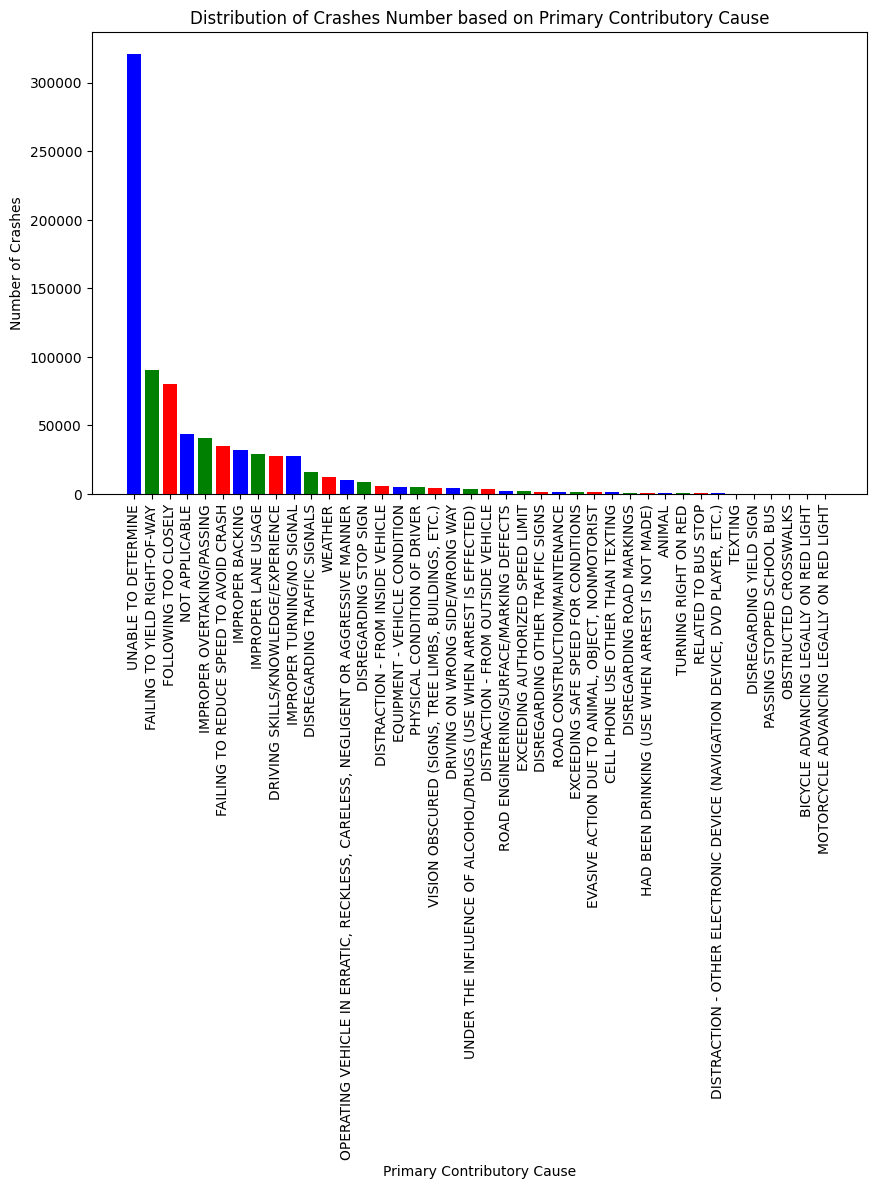

In [ ]:
prim_contibutory_cause = crashes_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(prim_contibutory_cause.index, prim_contibutory_cause.values, color=['blue', 'green', 'red'])
plt.xlabel('Primary Contributory Cause')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Crashes Number based on Primary Contributory Cause')
plt.xticks(rotation=90)
plt.show()

The primary cause of most accidents is unknown (unable to determine), this means that:
- there might not be enough police on the roads to determine the cause.
- or people are not admitting why they caused a crash.

### [ii]

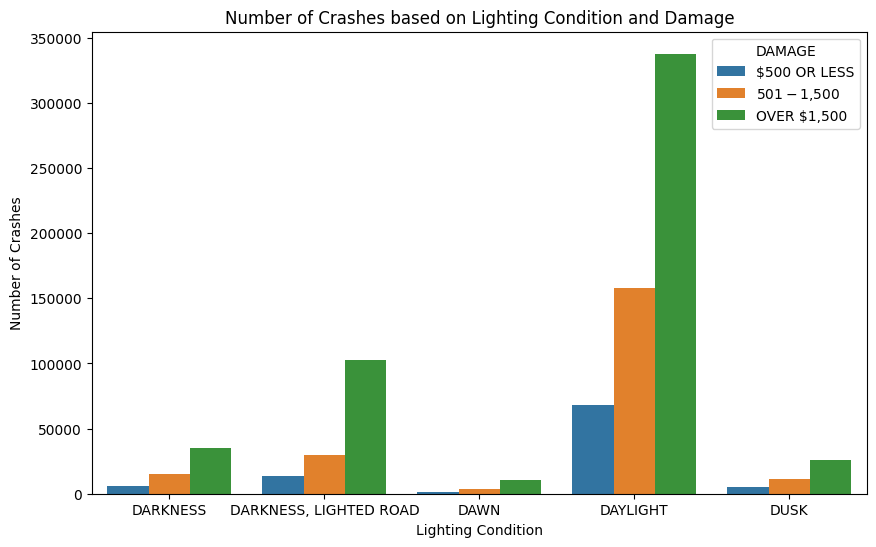

In [ ]:
grouped_df = crashes_df.groupby(['LIGHTING_CONDITION', 'DAMAGE']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.barplot(x='LIGHTING_CONDITION', y='NUM_CRASHES', hue='DAMAGE', data=grouped_df)
plt.xlabel('Lighting Condition')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes based on Lighting Condition and Damage')
plt.show()


Lack of lighting does not increase accidents, on the contrary, for example, we notice that the number of accidents where the cost of damage is higher tends to occur in daylight. And if we compare the cost of damage from accidents that occur at night, whether the road is lit or not, we notice that the cost of accidents is higher with the presence of a lit road.

This could be due to two reasons, the first one being that when there is no lighting, there is no congestion, meaning fewer accidents. The second reason is that with reduced lighting, drivers tend to be more cautious.

### [iii]

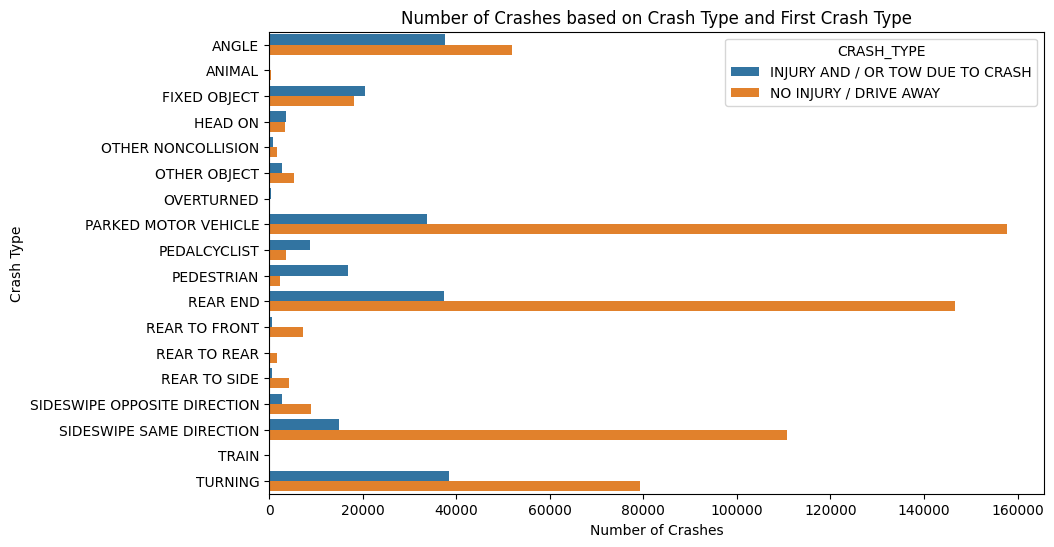

In [ ]:
grouped_df = crashes_df.groupby(['CRASH_TYPE', 'FIRST_CRASH_TYPE']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.barplot(x='NUM_CRASHES', y='FIRST_CRASH_TYPE', hue='CRASH_TYPE', data=grouped_df)
plt.xlabel('Number of Crashes')
plt.ylabel('Crash Type')
plt.title('Number of Crashes based on Crash Type and First Crash Type')
plt.show()


Most accindents are injury-free, and most of the them are due to a parked motor vehicle, which means that either there are not enough suitable places to park the motors, or there are enough places to park them but they are not located in a suitable place.

A high percentage of accidents occur due to rear-end collisions, indicating there are many sudden stops, possibly because the number of speed bumps or traffic signals is large.

There is also a high percentage of side-impact accidents, possibly because the road is congested, so some drivers try to overtake others and end up colliding from the side.

A high percentage of accidents occur at turns, which might be because most of the turns are blind, so we could increase the drivers' visibility by installing mirrors that show the blind spots on the road.

### [iv]

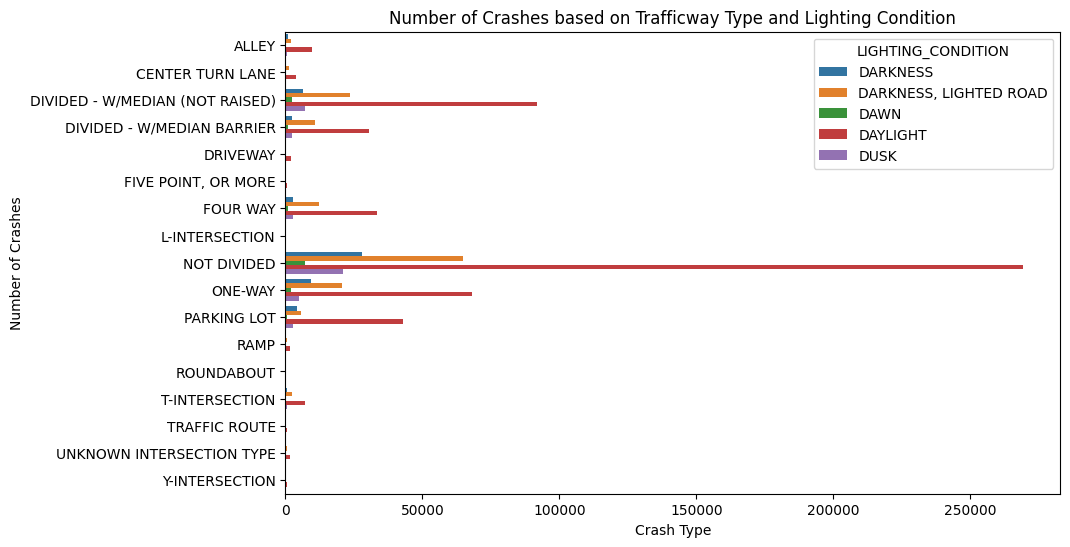

In [ ]:
grouped_df = crashes_df.groupby(['TRAFFICWAY_TYPE', 'LIGHTING_CONDITION']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.barplot(x='NUM_CRASHES', y='TRAFFICWAY_TYPE', hue='LIGHTING_CONDITION', data=grouped_df)
plt.xlabel('Crash Type')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes based on Trafficway Type and Lighting Condition')
plt.show()

Most accidents occur during daylight and at night when the road is lit, which corresponds with our second chart. A high percentage of accidents occur in vehicle parking spots, which aligns with our conclusion in the third chart.

We also notice that most accidents occur on roads that are not divided, or are divided but with low edges. Therefore, adding dividers to the roads could reduce these accidents.

## [b] Traffic Accidents History


### [i]

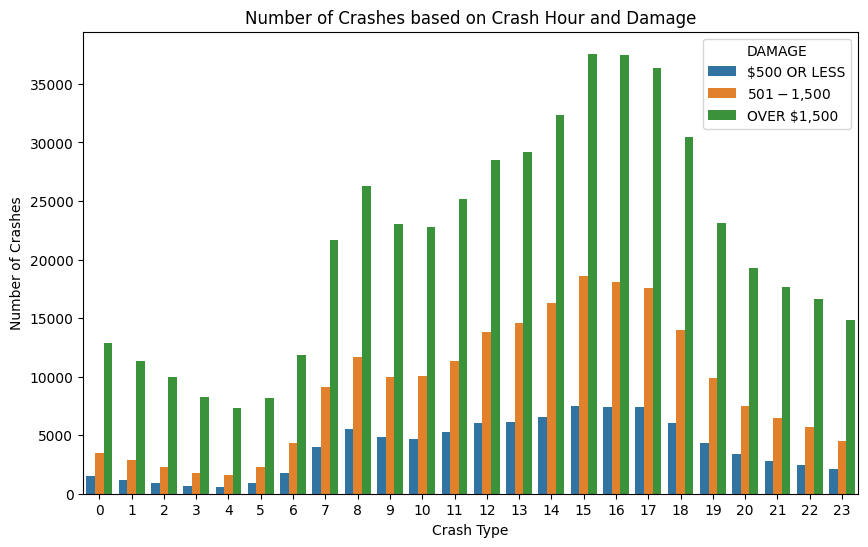

In [ ]:
grouped_df = crashes_df.groupby(['CRASH_HOUR', 'DAMAGE']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.barplot(x='CRASH_HOUR', y='NUM_CRASHES', hue='DAMAGE', data=grouped_df)
plt.xlabel('Crash Type')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes based on Crash Hour and Damage')
plt.show()

We notice an increase in the rate of accidents at 8 AM compared to 7 AM and 9 AM, which may indicate that there is a sudden rush at this time as employees are heading to their jobs. We also find an increase in accidents from 3 PM to 5 PM, which is the time when employees are returning from work. Most of the accidents tend to have a high cost.

### [ii]

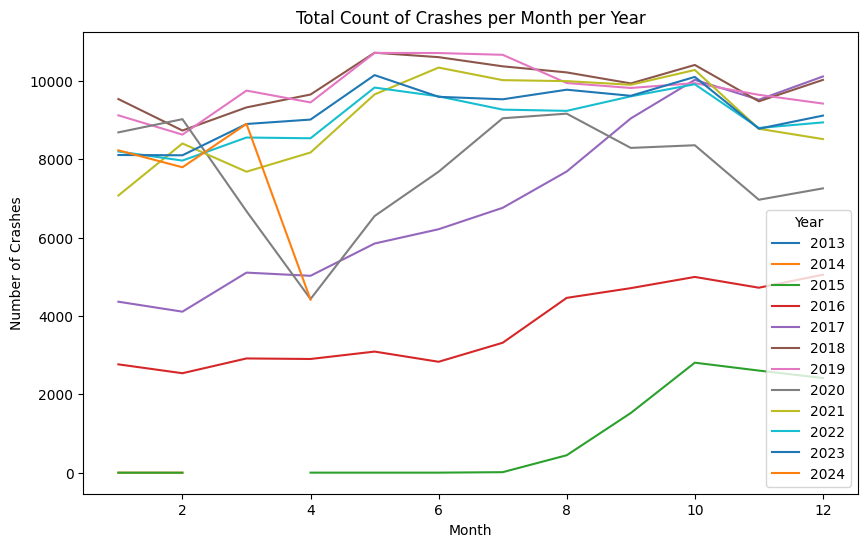

In [ ]:
grouped_df = crashes_df.groupby(['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='NUM_CRASHES')

pivot_df = grouped_df.pivot(index='CRASH_MONTH', columns='CRASH_YEAR', values='NUM_CRASHES')

plt.figure(figsize=(10, 6))
plt.plot(pivot_df)
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.title('Total Count of Crashes per Month per Year')
plt.legend(title='Year', labels=pivot_df.columns)
plt.show()


The number of accidents are high in all years, but we see a drop in 2020, during April and May and this might be due to the pandemic (Covid-19). We also see a drop in 2024, and this might be to data cut-off (the data ends here).

### [iii]

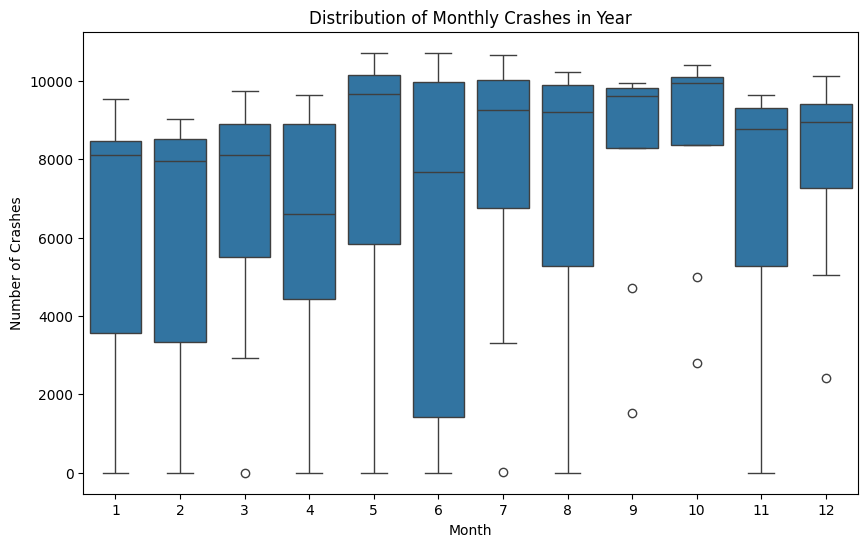

In [ ]:
grouped_df = crashes_df.groupby(['CRASH_MONTH', 'CRASH_YEAR']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.boxplot(x='CRASH_MONTH', y='NUM_CRASHES', data=grouped_df)
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Monthly Crashes in Year')
plt.show()


In September and October, the number of accidents ranges between 8000 and 10000, which is the highest accident rate. This could be because it is the start of the school year and most people who were vacationing outside the city are returning around this time.

### [iv]

In [ ]:
grouped_df = crashes_df.groupby(['CRASH_DAY_OF_WEEK', 'DAMAGE']).size().reset_index(name='NUM_CRASHES')

fig = px.sunburst(grouped_df, path=['CRASH_DAY_OF_WEEK', 'DAMAGE'], values='NUM_CRASHES')
fig.show()

The majority of accidents tend to have a high cost, and the likelihood of an accident occurring is equal on all days of the week.

## [c] Spatial Analysis


### [i]

In [ ]:
def GetGeohash(latitude, longitude, precision):
  return geohash.encode(latitude=latitude, longitude=longitude, precision=precision)

In [ ]:

crashes_df['GEOHASH'] = crashes_df.apply(lambda x: GetGeohash(x['LATITUDE'], x['LONGITUDE'], 5), axis=1)


In [ ]:
print(crashes_df[['DAMAGE', 'distance_to_polygon_km']].dtypes)

DAMAGE                     object
distance_to_polygon_km    float64
dtype: object


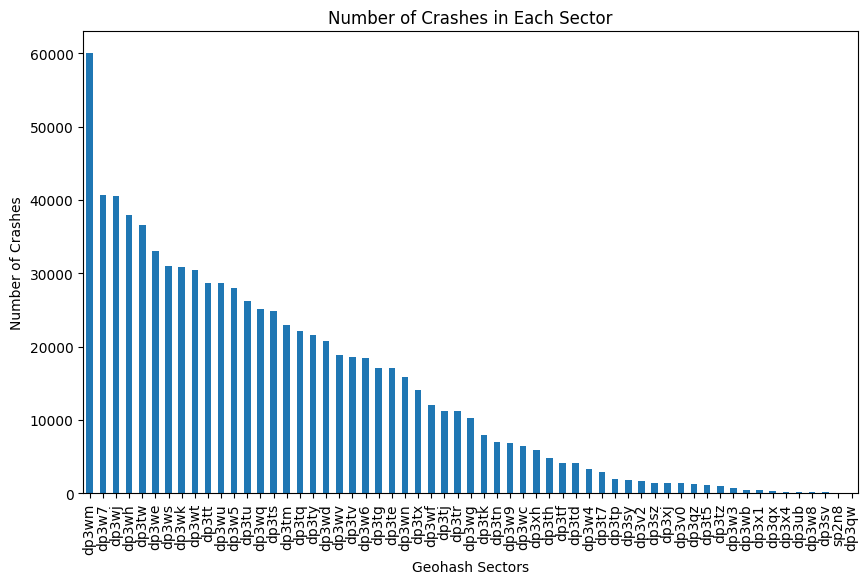

In [ ]:
counts = crashes_df['GEOHASH'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
counts.plot(kind='bar')
plt.xlabel('Geohash Sectors')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes in Each Sector')
plt.show()


We noticed that the section dp3wm has around 60000 accidents where the other sectos has close number of accidents.
We notice that sectors starting from dp3th has low rate of accidents and two sectors have zero rate of accident

### [ii]

In [ ]:
unique_values = crashes_df[crashes_df['distance_to_polygon_km'] > 40]['distance_to_polygon_km'].unique()
print(unique_values)

[8452.05649528 8452.05784117]


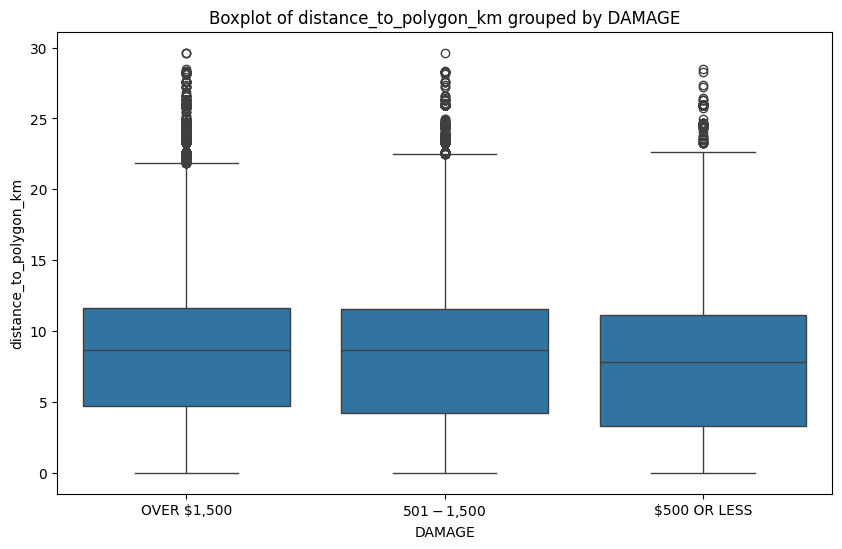

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='DAMAGE', y='distance_to_polygon_km', data=crashes_df)
plt.title('Boxplot of distance_to_polygon_km grouped by DAMAGE')
plt.show()


We noticed that with higher damage the distance increases which is compatible to what we found regarding the number of crashes according to the distance


### [iii]

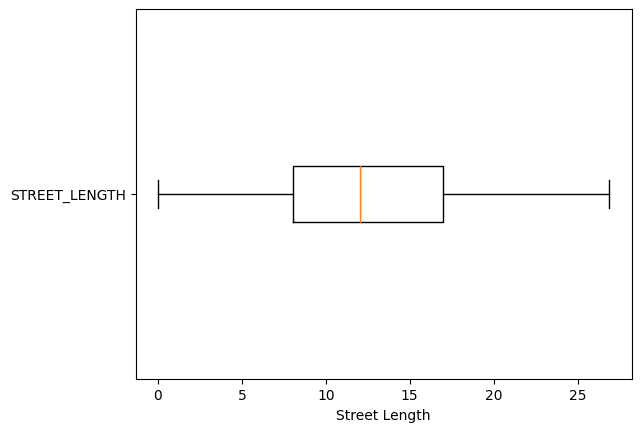

In [ ]:
merged_df = pd.merge(crashes_df, people_df[['CRASH_RECORD_ID', 'CITY']], on='CRASH_RECORD_ID', how='left')
plt.figure(figsize=(10, 6))
sns.boxplot(x='CITY', y='STREET_LENGTH', data=merged_df)
plt.xlabel('City')
plt.ylabel('Street Length')
plt.title('Box Plot of Street Length for Each City')
plt.xticks(rotation=90)
plt.show()



We notice that some citites with longer streets have the higher rates of accidents.

### [iv]

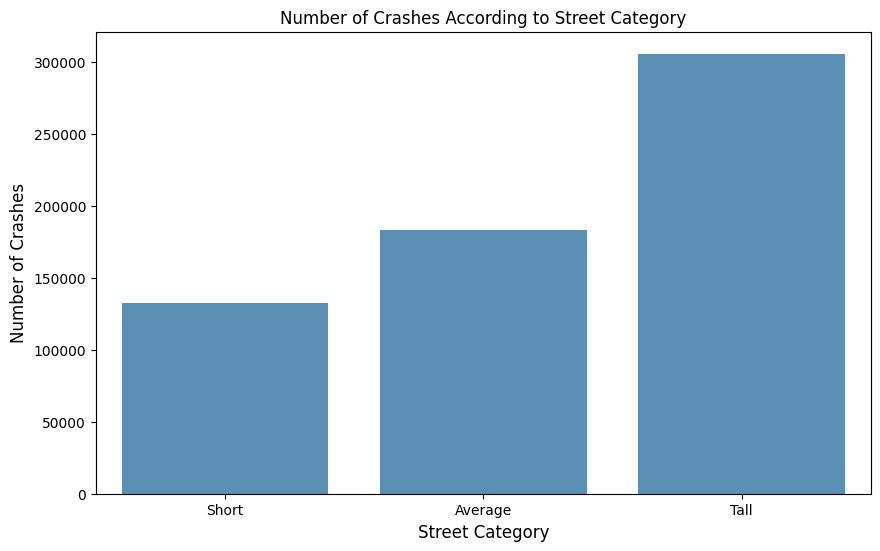

In [ ]:

category_counts = crashes_df['Length_CATEGORIES'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index, y=category_counts.values, alpha=0.8)

plt.title('Number of Crashes According to Street Category')
plt.ylabel('Number of Crashes', fontsize=12)
plt.xlabel('Street Category', fontsize=12)

plt.show()


We noticed that the taller the street is the more accidents heppen which is ligical since the we have nore cars and different speeds

### [v]

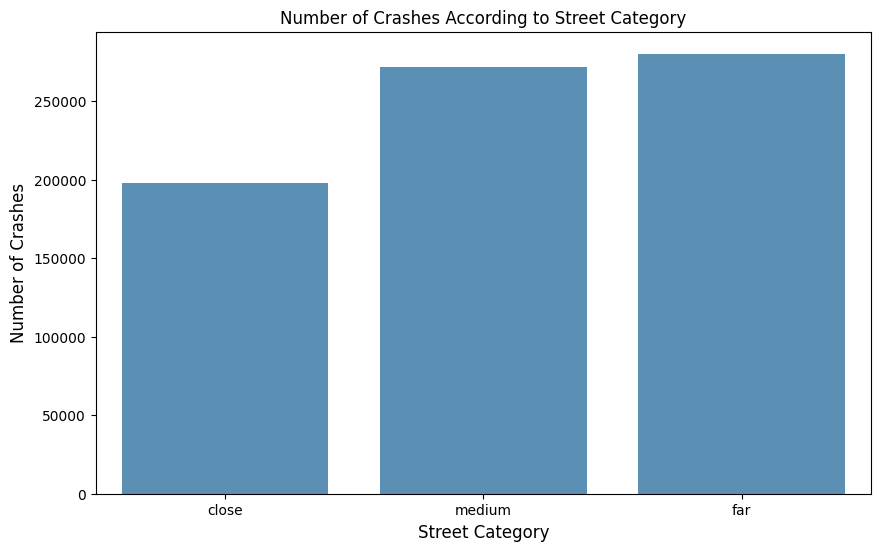

In [ ]:
category_counts = crashes_df['distance_category'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index, y=category_counts.values, alpha=0.8)

plt.title('Number of Crashes According to Street Category')
plt.ylabel('Number of Crashes', fontsize=12)
plt.xlabel('Street Category', fontsize=12)

plt.show()



We noticed that the accidents happen more when in far from the central dstrict which could be attributed to the police stations and organized area.
and the lowest rate of accidents happen in the close area.

### [vi]

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(crashes_df['Length_CATEGORIES'], crashes_df['distance_category'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"The test statistic is {chi2} with a p-value of {p}")


The test statistic is 18703.654045547588 with a p-value of 0.0


### [vii]

In the Chi-square test conducted, a test statistic of 18376.712409884454 was obtained. This high value indicates a substantial discrepancy between the observed data and the expected data, assuming there was no association between the variables.

The p-value, which is 0.0, is significantly less than the conventional threshold of 0.05. This suggests that the probability of obtaining such a Chi-square value by chance, given no association in the population, is extremely low.

Therefore, the test provides strong evidence to reject the null hypothesis of no association. It can be concluded that there is a statistically significant association between the two categorical variables under consideration. This implies that the variables are not independent and have some form of relationship.


## [d] Passengers Cases Analysis


### [i]

In this step we will get the required features and merge them together

In [266]:
vehicles_subset_df = vehicles_df[['CRASH_RECORD_ID', 'VEHICLE_YEAR', 'YEAR_CLASS']]

crashes_subset_df = crashes_df[['CRASH_RECORD_ID', 'CRASH_YEAR']]

merged_df = people_df.merge(vehicles_subset_df, on='CRASH_RECORD_ID', how='left')
merged_df = merged_df.merge(crashes_subset_df, on='CRASH_RECORD_ID', how='left')


In [267]:
num_records = (merged_df['VEHICLE_YEAR'] < 1989).sum()
print(f"The number of records where VEHICLE_YEAR is below 1989 is {num_records}")


nan_ratio = merged_df['VEHICLE_YEAR'].isna().sum() / len(merged_df)
nan_ratio

The number of records where VEHICLE_YEAR is below 1989 is 11538


0.019690359457294727

In [268]:
y_ratio = num_records / len(merged_df)
y_ratio

0.003500521831994369

In [269]:
merged_df = merged_df[merged_df['VEHICLE_YEAR'] >= 1989]

merged_df = merged_df[merged_df['VEHICLE_YEAR'].notna()]


In [270]:
merged_df['YEAR_DIFFERENCE'] = merged_df['CRASH_YEAR'] - merged_df['VEHICLE_YEAR']


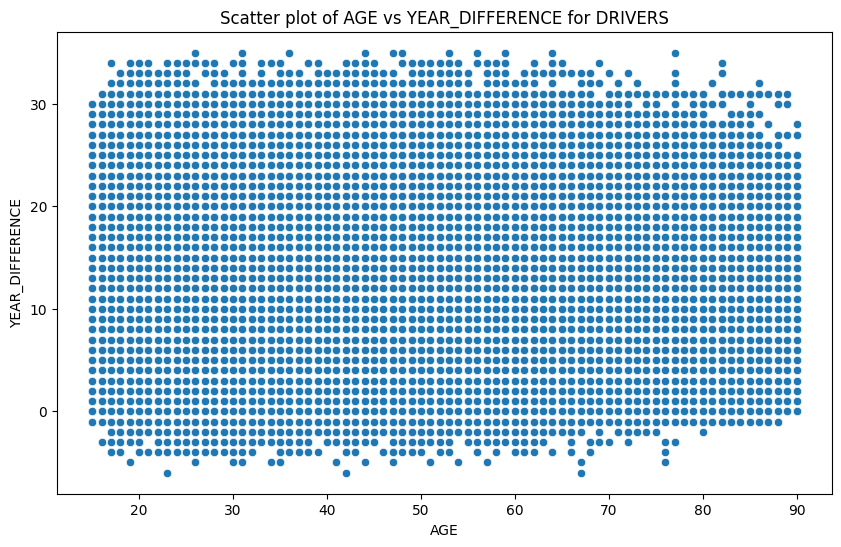

In [271]:
driver_df = merged_df[merged_df['PERSON_TYPE'] == 'DRIVER']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='YEAR_DIFFERENCE', data=driver_df)

plt.title('Scatter plot of AGE vs YEAR_DIFFERENCE for DRIVERS')
plt.xlabel('AGE')
plt.ylabel('YEAR_DIFFERENCE')

plt.show()

from this scatter plot we can notice that all ages in chicago make accidents driving new vars which are the commonly used in us. While yong and old ages don't use old cars since yaong tend to new cars and old people can afford them.

[ii]

In [272]:
bins = [0, 25, 55, np.inf]

labels = ['Young', 'Middle', 'Old']

merged_df['AGE_CATEGORY'] = pd.cut(merged_df['AGE'], bins=bins, labels=labels)



In [273]:
driver_df = merged_df[merged_df['PERSON_TYPE'] == 'DRIVER']

contingency_table = pd.crosstab(driver_df['AGE_CATEGORY'], driver_df['YEAR_CLASS'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

Chi-Square Statistic: 1938.2703085299327
P-value: 0.0
Degrees of Freedom: 4


since the p-score is 0 which is lower than 0.05 then we can say that there is a relationship bewteen both featuers

### [iii]

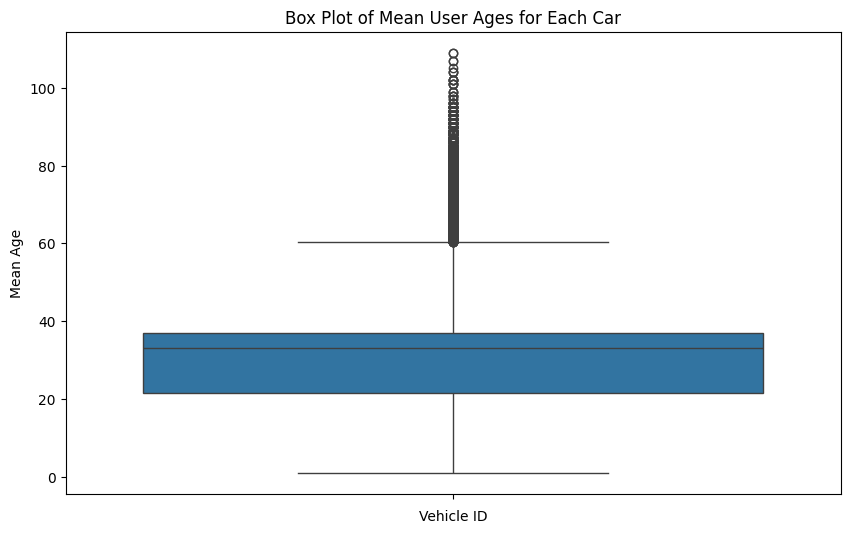

In [274]:

filtered_df = merged_df[merged_df['PERSON_TYPE'] != 'DRIVER']

grouped_df_new = filtered_df.groupby('CRASH_RECORD_ID')
mean_ages = grouped_df_new['AGE'].mean()

plt.figure(figsize=(10, 6))
sns.boxplot(y=mean_ages.values)
plt.xlabel('Vehicle ID')
plt.ylabel('Mean Age')
plt.title('Box Plot of Mean User Ages for Each Car')
plt.show()


### [iv]

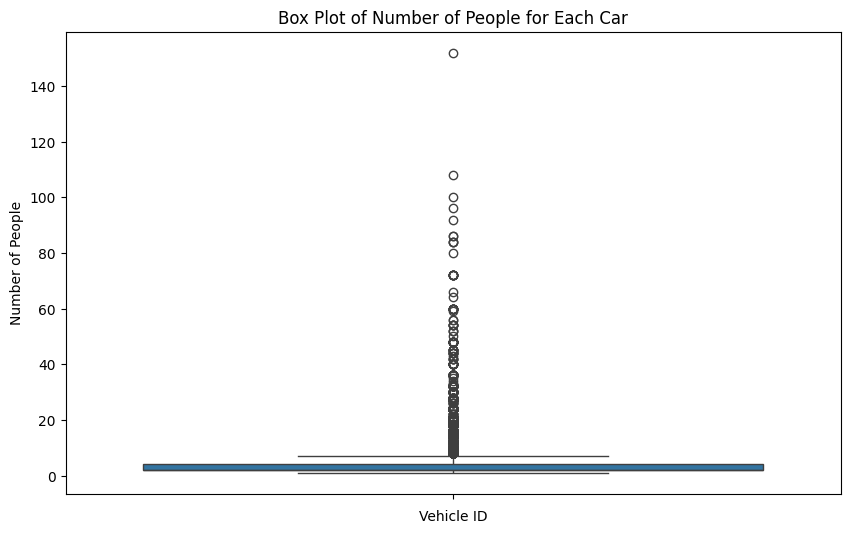

In [275]:
filtered_df = merged_df[merged_df['PERSON_TYPE'] != 'DRIVER']

grouped_df = filtered_df.groupby('VEHICLE_ID')
count_people = grouped_df.size()

plt.figure(figsize=(10, 6))
sns.boxplot(y=count_people.values)
plt.xlabel('Vehicle ID')
plt.ylabel('Number of People')
plt.title('Box Plot of Number of People for Each Car')
plt.show()


We can see that most of the valeus are around two which is logical that the number of poeple in each car execluding the driver is one.
We can attribute the high number of people to the public transportation that a bus could have more than 20 people in each unique eccident. So the the number of people is between 1 and 5 where some values are high in the public transportation.

### [v]

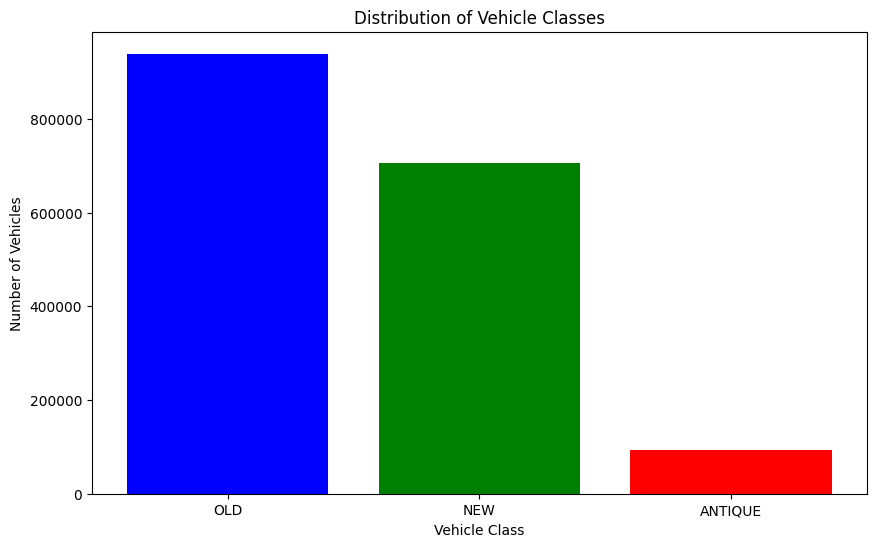

In [276]:
year_class_counts = vehicles_df['YEAR_CLASS'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(year_class_counts.index, year_class_counts.values, color=['blue', 'green', 'red'])
plt.xlabel('Vehicle Class')
plt.ylabel('Number of Vehicles')
plt.title('Distribution of Vehicle Classes')
plt.show()

It is logical that old cars are more likely to have accedients since thay can have issues and they had mroe than one accident. where new cars have newer technologies and weren't used as mush as old cars so engaged in less number of accidents.
Antique cars are the lowest because thay usually are used to purposes than transportaion. They could be used in exhibiting shows and galleries.

### [vi]

we explained all of the plots and what concluded from them.
In addition to that from the entire study of all plots we noticed that yound people of age 20 to 40 were the most engaged in the accidents.
We also noticed the around the central district (not the closest area to cbd), most of the accidents happen there we also noticed that some cities have high ratio of accidents comparing to other cities. From the relation between the  driver vision, street and citiy feauters we noticed that in some cities there are some circumstances that cause difficulty in vision which cause accidents.

## [e] Outlier Detection

### [i]

We will approach the problem of detecting outliers leveraging our knowledge of the domain.

In [277]:
crashes_df['WEATHER_CONDITION'].value_counts()

CLEAR                       691447
RAIN                         74389
SNOW                         28954
CLOUDY/OVERCAST              24450
FREEZING RAIN/DRIZZLE         1719
FOG/SMOKE/HAZE                1338
SLEET/HAIL                    1007
BLOWING SNOW                   444
SEVERE CROSS WIND GATE         153
BLOWING SAND, SOIL, DIRT         7
Name: WEATHER_CONDITION, dtype: int64

We notice that there is 7 occurances of `BLOWING SAND, SOIL, DIRT`. However, considering that Chicago is located in the northern hemisphere of our planet, where the weather tends to be cold or moderate, let's examine the dates associated with these occurrences.

In [278]:
crashes_df[crashes_df['WEATHER_CONDITION'] == 'BLOWING SAND, SOIL, DIRT']['CRASH_DATE']

4340      07/26/2023 10:01:00 PM
26024     08/03/2020 10:05:00 AM
45346     01/16/2022 12:50:00 PM
335104    06/20/2023 02:50:00 AM
473498    03/08/2023 09:58:00 PM
585140    05/13/2022 04:51:00 PM
703748    02/08/2020 03:00:00 PM
Name: CRASH_DATE, dtype: object

According to this [source](https://www.nbcchicago.com/news/local/how-often-dust-storms-happen-illinois/3132280/) sand storms are generally rare in chicago and mostly occure in May and June. Therefore, we may classify sandstorms that happen on other dates as outliers.

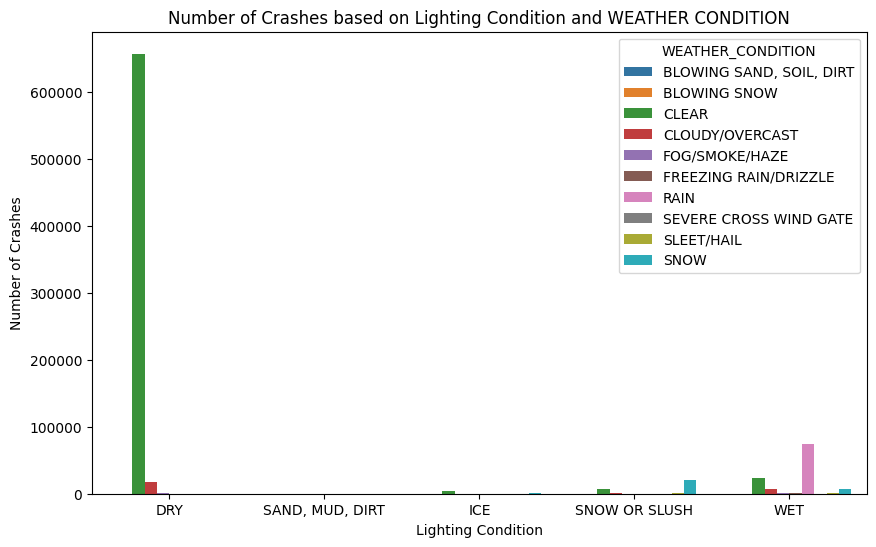

In [279]:
grouped_df = crashes_df.groupby(['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND']).size().reset_index(name='NUM_CRASHES')

plt.figure(figsize=(10, 6))
sns.barplot(x='ROADWAY_SURFACE_COND', y='NUM_CRASHES', hue='WEATHER_CONDITION', data=grouped_df)
plt.xlabel('Lighting Condition')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes based on Lighting Condition and WEATHER CONDITION')
plt.show()

We can also say that whenever roadway surface is dry but it's raining, then this is an outlier, or if it's raining in the summer, then this is also an outlier.

In [280]:
crashes_df[(crashes_df['WEATHER_CONDITION'] == 'RAIN') & (crashes_df['CRASH_MONTH'] == 7)]['CRASH_DATE'].notna().sum()

3979

Now, we will move forward to checking for outliers in `VEHICLE_YEAR`.

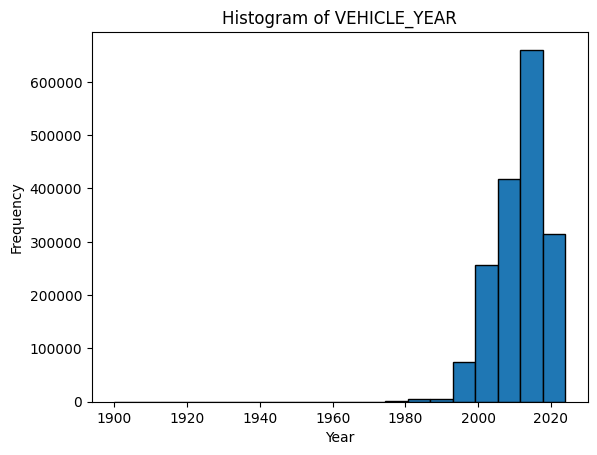

In [281]:
plt.hist(vehicles_df['VEHICLE_YEAR'], bins=20, edgecolor='black')

plt.title('Histogram of VEHICLE_YEAR')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.show()


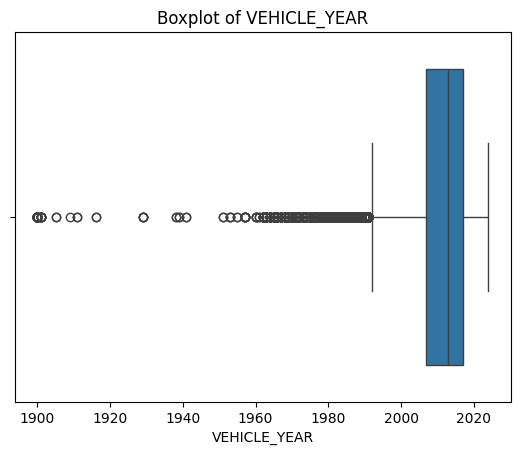

In [282]:
sns.boxplot(x=vehicles_df['VEHICLE_YEAR'])
plt.title('Boxplot of VEHICLE_YEAR')
plt.show()

Since `VEHICLE_YEAR` is a numerical value, we will use IQR to detect the outliers.

In [283]:
Q1 = vehicles_df['VEHICLE_YEAR'].quantile(0.25)
Q3 = vehicles_df['VEHICLE_YEAR'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = vehicles_df[(vehicles_df['VEHICLE_YEAR'] < lower_bound) | (vehicles_df['VEHICLE_YEAR'] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 10823


# Question [4]: Do What you Have to Do

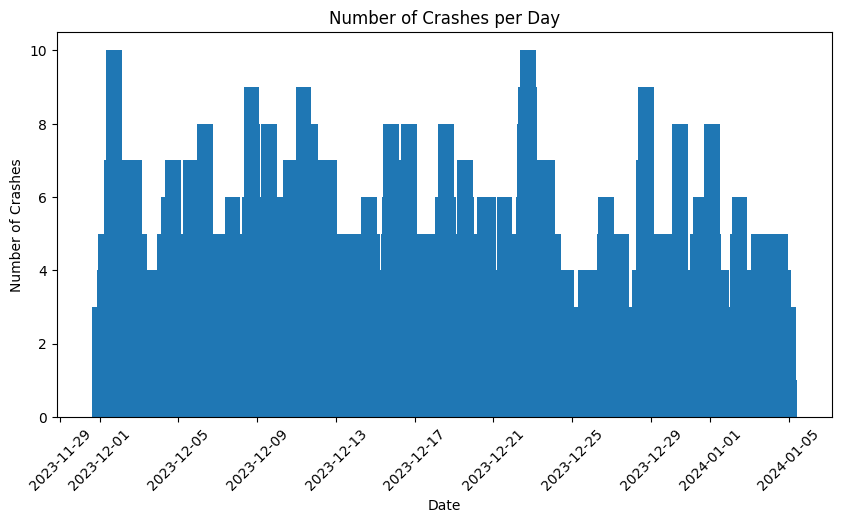

In [284]:
crashes_df['CRASH_DATE_datetime'] = pd.to_datetime(crashes_df['CRASH_DATE'])

start_date = '2023-12-01'
end_date = '2024-01-05'
mask = (crashes_df['CRASH_DATE_datetime'] >= start_date) & (crashes_df['CRASH_DATE_datetime'] <= end_date)
filtered_df = crashes_df.loc[mask]

crash_counts = filtered_df['CRASH_DATE_datetime'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(crash_counts.index, crash_counts.values)
plt.title('Number of Crashes per Day')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.show()

We notice that there was a slight increase in crashes in the days before Christmas (25 December), followed by a decrease on Christmas day. This pattern might be attributed to heavy traffic jams before Christmas, while people tend to stay at home and celebrate with their loved ones on Christmas day. The period between Christmas and New Year's Eve sees another rise, maybe because people tend to celebrate this event outside. Finally, crashes again decrease on January 2nd, possibly due to people being tired after celebration so they stay home and rest. So maybe we should increase safety measures on these days.

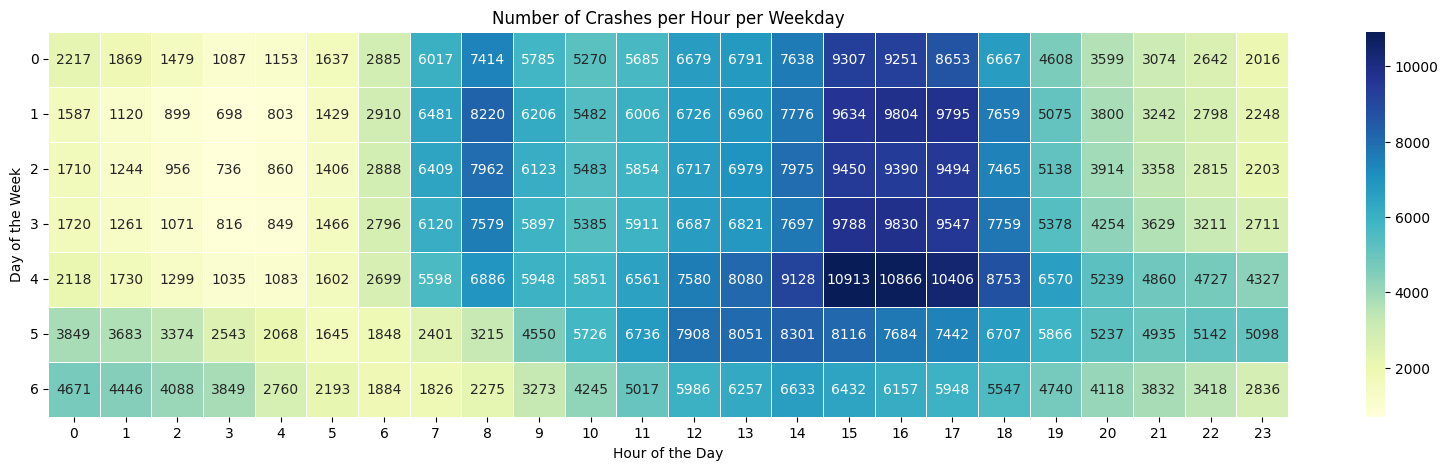

In [285]:
pivot_table = crashes_df.pivot_table(index='CRASH_DAY_OF_WEEK', columns='CRASH_HOUR', aggfunc='size', fill_value=0)

plt.figure(figsize=(20, 5))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Number of Crashes per Hour per Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


The heatmap reveals a pattern of increased crash frequencies during typical rush hours (7-8 AM and 3-6 PM). This is particularly obvious on Fridays (row 5), potentially due to a combination of end-of-week fatigue and the rush to return home after a long day.

Additionally, a slight rise in crashes is observed during late nights (12 AM - 2 AM) on weekends (rows 5 and 6), which could be associated with increased nighttime activity on weekends.